# [Smartwatch Gestures Dataset](https://tev.fbk.eu/resources/smartwatch)

A dataset collected to evaluate gesture recognition algorithms for interacting with mobile applications using arm gestures.

The SmartWatch Gestures Dataset has been collected to evaluate several gesture recognition algorithms for interacting with mobile applications using arm gestures.

Eight different users performed twenty repetitions of twenty different gestures, for a total of 3200 sequences. Each sequence contains acceleration data from the 3-axis accelerometer of a first generation Sony SmartWatch™, as well as timestamps from the different clock sources available on an Android device. The smartwatch was worn on the user's right wrist. The gestures have been manually segmented by the users performing them by tapping the smartwatch screen at the beginning and at the end of every repetition.

**Disclaimer: SmartWatch Gestures Dataset is provided for research or academic purposes only. Publications and works that use this dataset should please refer to one of the papers referenced below.**

# Publications 

* G. Costante, L. Porzi, O. Lanz, P. Valigi, E. Ricci, [Personalizing a Smartwatch-based Gesture Interface With Transfer Learning](http://www.google.com/url?q=http%3A%2F%2Fwww.eurasip.org%2FProceedings%2FEusipco%2FEusipco2014%2FHTML%2Fpapers%2F1569922319.pdf&sa=D&sntz=1&usg=AOvVaw3o-AErJ6J6zO4hNidkW5uD), 22nd European Signal Processing Conference, EUSIPCO 2014

* L. Porzi and S. Messelodi and C.M. Modena and E. Ricci: [A Smart Watch-based Gesture Recognition System for Assisting People with Visual Impairments](https://www.google.com/url?q=https%3A%2F%2Fdoi.org%2F10.1145%2F2505483.2505487&sa=D&sntz=1&usg=AOvVaw3mWoxp7VFIMYX372aR2Yl9). ACM International Workshop on Interactive Multimedia on Mobile and Portable Devices  - IMMPD, Barcelona, Spain, 2013 

# Data Source

[Source dataset](https://drive.google.com/a/fbk.eu/file/d/1nEs-JlAQv6xpuSIqahTKK68TgK37GirP/view?usp=sharing)

In [1]:
# General imports
import os
import zipfile
import random
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
# Google Drive download helper
import gdown
# For loop timer
from tqdm import tqdm
import time
# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn libraries
from skimage.transform import resize
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
# Wavelets
import pywt
# Tensorflow layers, models and callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Rescaling, Masking
from tensorflow.keras.callbacks import ModelCheckpoint
# scipy
from scipy import signal

TensorFlow version: 2.9.1


# Set random seed

In [2]:
SEED = 42

# set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED)

# set the random seed for: python, numpy and tensorflow
tf.keras.utils.set_random_seed(SEED)

# Download and extract raw data

In [3]:
file_name = 'gestures-dataset.zip'
gd_id = '1nEs-JlAQv6xpuSIqahTKK68TgK37GirP'
gdown.download(id=gd_id, output=file_name, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1nEs-JlAQv6xpuSIqahTKK68TgK37GirP
To: /home/testspecimen/Repos/continuous-wavelets-cnn/gestures-dataset.zip
100%|██████████████████████████████████████| 2.16M/2.16M [00:00<00:00, 5.18MB/s]


'gestures-dataset.zip'

In [4]:
with zipfile.ZipFile(file_name, 'r') as archive:
    archive.extractall('.')

# Data information and plan

## The data

There are 8 users and each person performs 20 different movements, 20 times.

The raw data appears to be split as follows:

* First level of folders are each user (U01 to U08)
* Second level of folders are the gestures (01 to 20)
* The files withing each of the second level folders are the repetitions of each movement (0.1.txt to 20.txt)

It could be assumed that the folders represent the repititions and the files are each movement as there are 20 of each. However, on inspection of the files it is clear that each text file in a second level folder contains a timeseries of similar length, suggesting a similar movement. It is also consistently true that a complicated movement (movement 20) compared to a simple movement (movement 1) results in a longer timeseries.

## The plan

### Data split

Initially, I will use 7 of the 8 people as training and validation, and the 8th person as a holdout test set.

The 7 people will be completely randomised and then split 85%-15% (train-validation). The final outcome of the models being judged on the holdout test 'person'.

This should result in:

* training timeseries --> 2380 sequences
* validation timeseries --> 420 sequences
* testing timeseries --> 400 sequences

Total timeseries: 3200

### Models

The point of this notebook is to investigate the usefulness of the Continuous Wavelet Transform (CWT) as a method of extracting useful interpretable information from a timeseries to ultimately improve the overall accuracy of the model on unseen data.

The models that will be created are as follows:

1. Model 1 - A CNN model (Conv1D) used as a baseline on the raw timeseries data - this is the benchmark
2. Model 2 - A CNN model (Conv2D) utilising a CWT on the timeseries before input into the model
3. Model 3 - A CNN model (Conv2D) utilising a complex CWT on the timeseries before input into the model

All the above models will use the same parameters and number/type of layers to keep them as comparable as possible. 

### Comparison

#### Stage 1

A single run (Users 1 to 7 as train/val, User 8 as test) of the model to get an idea of accuracy and see where the model is failing (or succeeding) to generalise.

#### Stage 2

Ten runs (Users 1 to 7 as train/val, User 8 as test) to get a more accurate average accuracy, which takes better account of general model randomness.

#### Stage 3 

For Model 1 and either Model 2 or 3 (depending which performs best), a cross validation of users will be performed. Essentially, each individial user (1 to 8) will be used as the hold out test set in a completely independent set of tests. Each set of tests will be repeated 10 times (like Stage 2) to get an average accuracy. 

This will give a good indication as to how the models perform for each individual, and will also give a better indication of how the model will likely perform with a completely new user in the future.


# Extract data

In [5]:
file_paths = []
for root, dirs, files in os.walk('gestures-dataset'):
    for item in files:
        if dirs == []:
            file_paths.append(f'{root}/{item}')

file_paths[0:10]

['gestures-dataset/U01/01/01.txt',
 'gestures-dataset/U01/01/02.txt',
 'gestures-dataset/U01/01/03.txt',
 'gestures-dataset/U01/01/04.txt',
 'gestures-dataset/U01/01/05.txt',
 'gestures-dataset/U01/01/06.txt',
 'gestures-dataset/U01/01/07.txt',
 'gestures-dataset/U01/01/08.txt',
 'gestures-dataset/U01/01/09.txt',
 'gestures-dataset/U01/01/10.txt']

# Inital exploration of the data

In [6]:
header_names = ['time_millis', 'time_nano', 'time_event', 'accel_x', 'accel_y', 'accel_z']

In [7]:
sample_data = pd.read_csv(file_paths[15], sep=' ', header=None, names=header_names)
sample_data.head()

,time_millis,time_nano,time_event,accel_x,accel_y,accel_z
0,1384186110828,79009117897452,1509422000000,0.459687,-0.306458,9.959879
1,1384186110940,79009230110587,1509532000000,0.766145,-0.612916,9.959879
2,1384186111051,79009340309561,1509642000000,1.991976,0.459687,9.653421
3,1384186111156,79009445961417,1509752000000,4.443638,3.064578,11.185710
4,1384186111267,79009557197989,1509862000000,6.742072,2.604892,11.492168


In [8]:
time_nano = sample_data.time_millis / 1000 - sample_data.time_millis[0] / 1000
time_nano

0     0.000
1     0.112
2     0.223
3     0.328
4     0.439
5     0.551
6     0.661
7     0.773
8     0.885
9     0.992
10    1.103
11    1.214
12    1.326
13    1.437
14    1.535
Name: time_millis, dtype: float64

In [9]:
time_event = sample_data.time_event / 1000000000 - sample_data.time_event[0] / 1000000000
time_event

0     0.00
1     0.11
2     0.22
3     0.33
4     0.44
5     0.55
6     0.66
7     0.77
8     0.88
9     0.99
10    1.10
11    1.21
12    1.32
13    1.43
14    1.54
Name: time_event, dtype: float64

Although time_millis appears to be a more accurate representation of the timesteps it is close enough to time_event that it makes very little difference in these circumstances.

time_event will therefore be used going forward

In [10]:
sample_data.index = sample_data.time_event / 1000000000 - sample_data.time_event[0] / 1000000000
sample_data.head()

,time_millis,time_nano,time_event,accel_x,accel_y,accel_z
time_event,,,,,,
0.00,1384186110828,79009117897452,1509422000000,0.459687,-0.306458,9.959879
0.11,1384186110940,79009230110587,1509532000000,0.766145,-0.612916,9.959879
0.22,1384186111051,79009340309561,1509642000000,1.991976,0.459687,9.653421
0.33,1384186111156,79009445961417,1509752000000,4.443638,3.064578,11.185710
0.44,1384186111267,79009557197989,1509862000000,6.742072,2.604892,11.492168


In [11]:
sample_data = sample_data.drop(['time_millis','time_nano','time_event'],axis=1)
sample_data.index.name = 'time_seconds'
sample_data

,accel_x,accel_y,accel_z
time_seconds,,,
0.00,0.459687,-0.306458,9.959879
0.11,0.766145,-0.612916,9.959879
0.22,1.991976,0.459687,9.653421
0.33,4.443638,3.064578,11.185710
0.44,6.742072,2.604892,11.492168
0.55,8.427590,-4.290410,9.500193
0.66,-1.072602,-10.726024,6.742072
0.77,0.000000,-6.435614,8.121132
0.88,-1.225831,-2.604892,9.346964


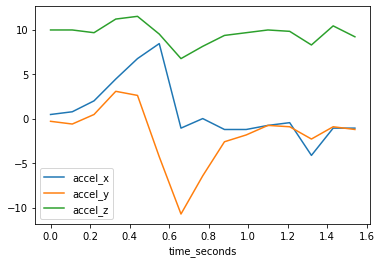

In [12]:
sample_data.plot();

# Difference in movements

In [13]:
total_files = len(file_paths)
user = 1
movements = []
for i in np.arange(1,21):
    for item in file_paths:
        current_user = int(item[-12:-10])
        current_movement = int(item[-9:-7])
        if (user == current_user and i == current_movement):
            current_file = np.loadtxt(item, delimiter=' ', converters=None, skiprows=0, usecols=(3,4,5))
            movements.append(current_file)
            break

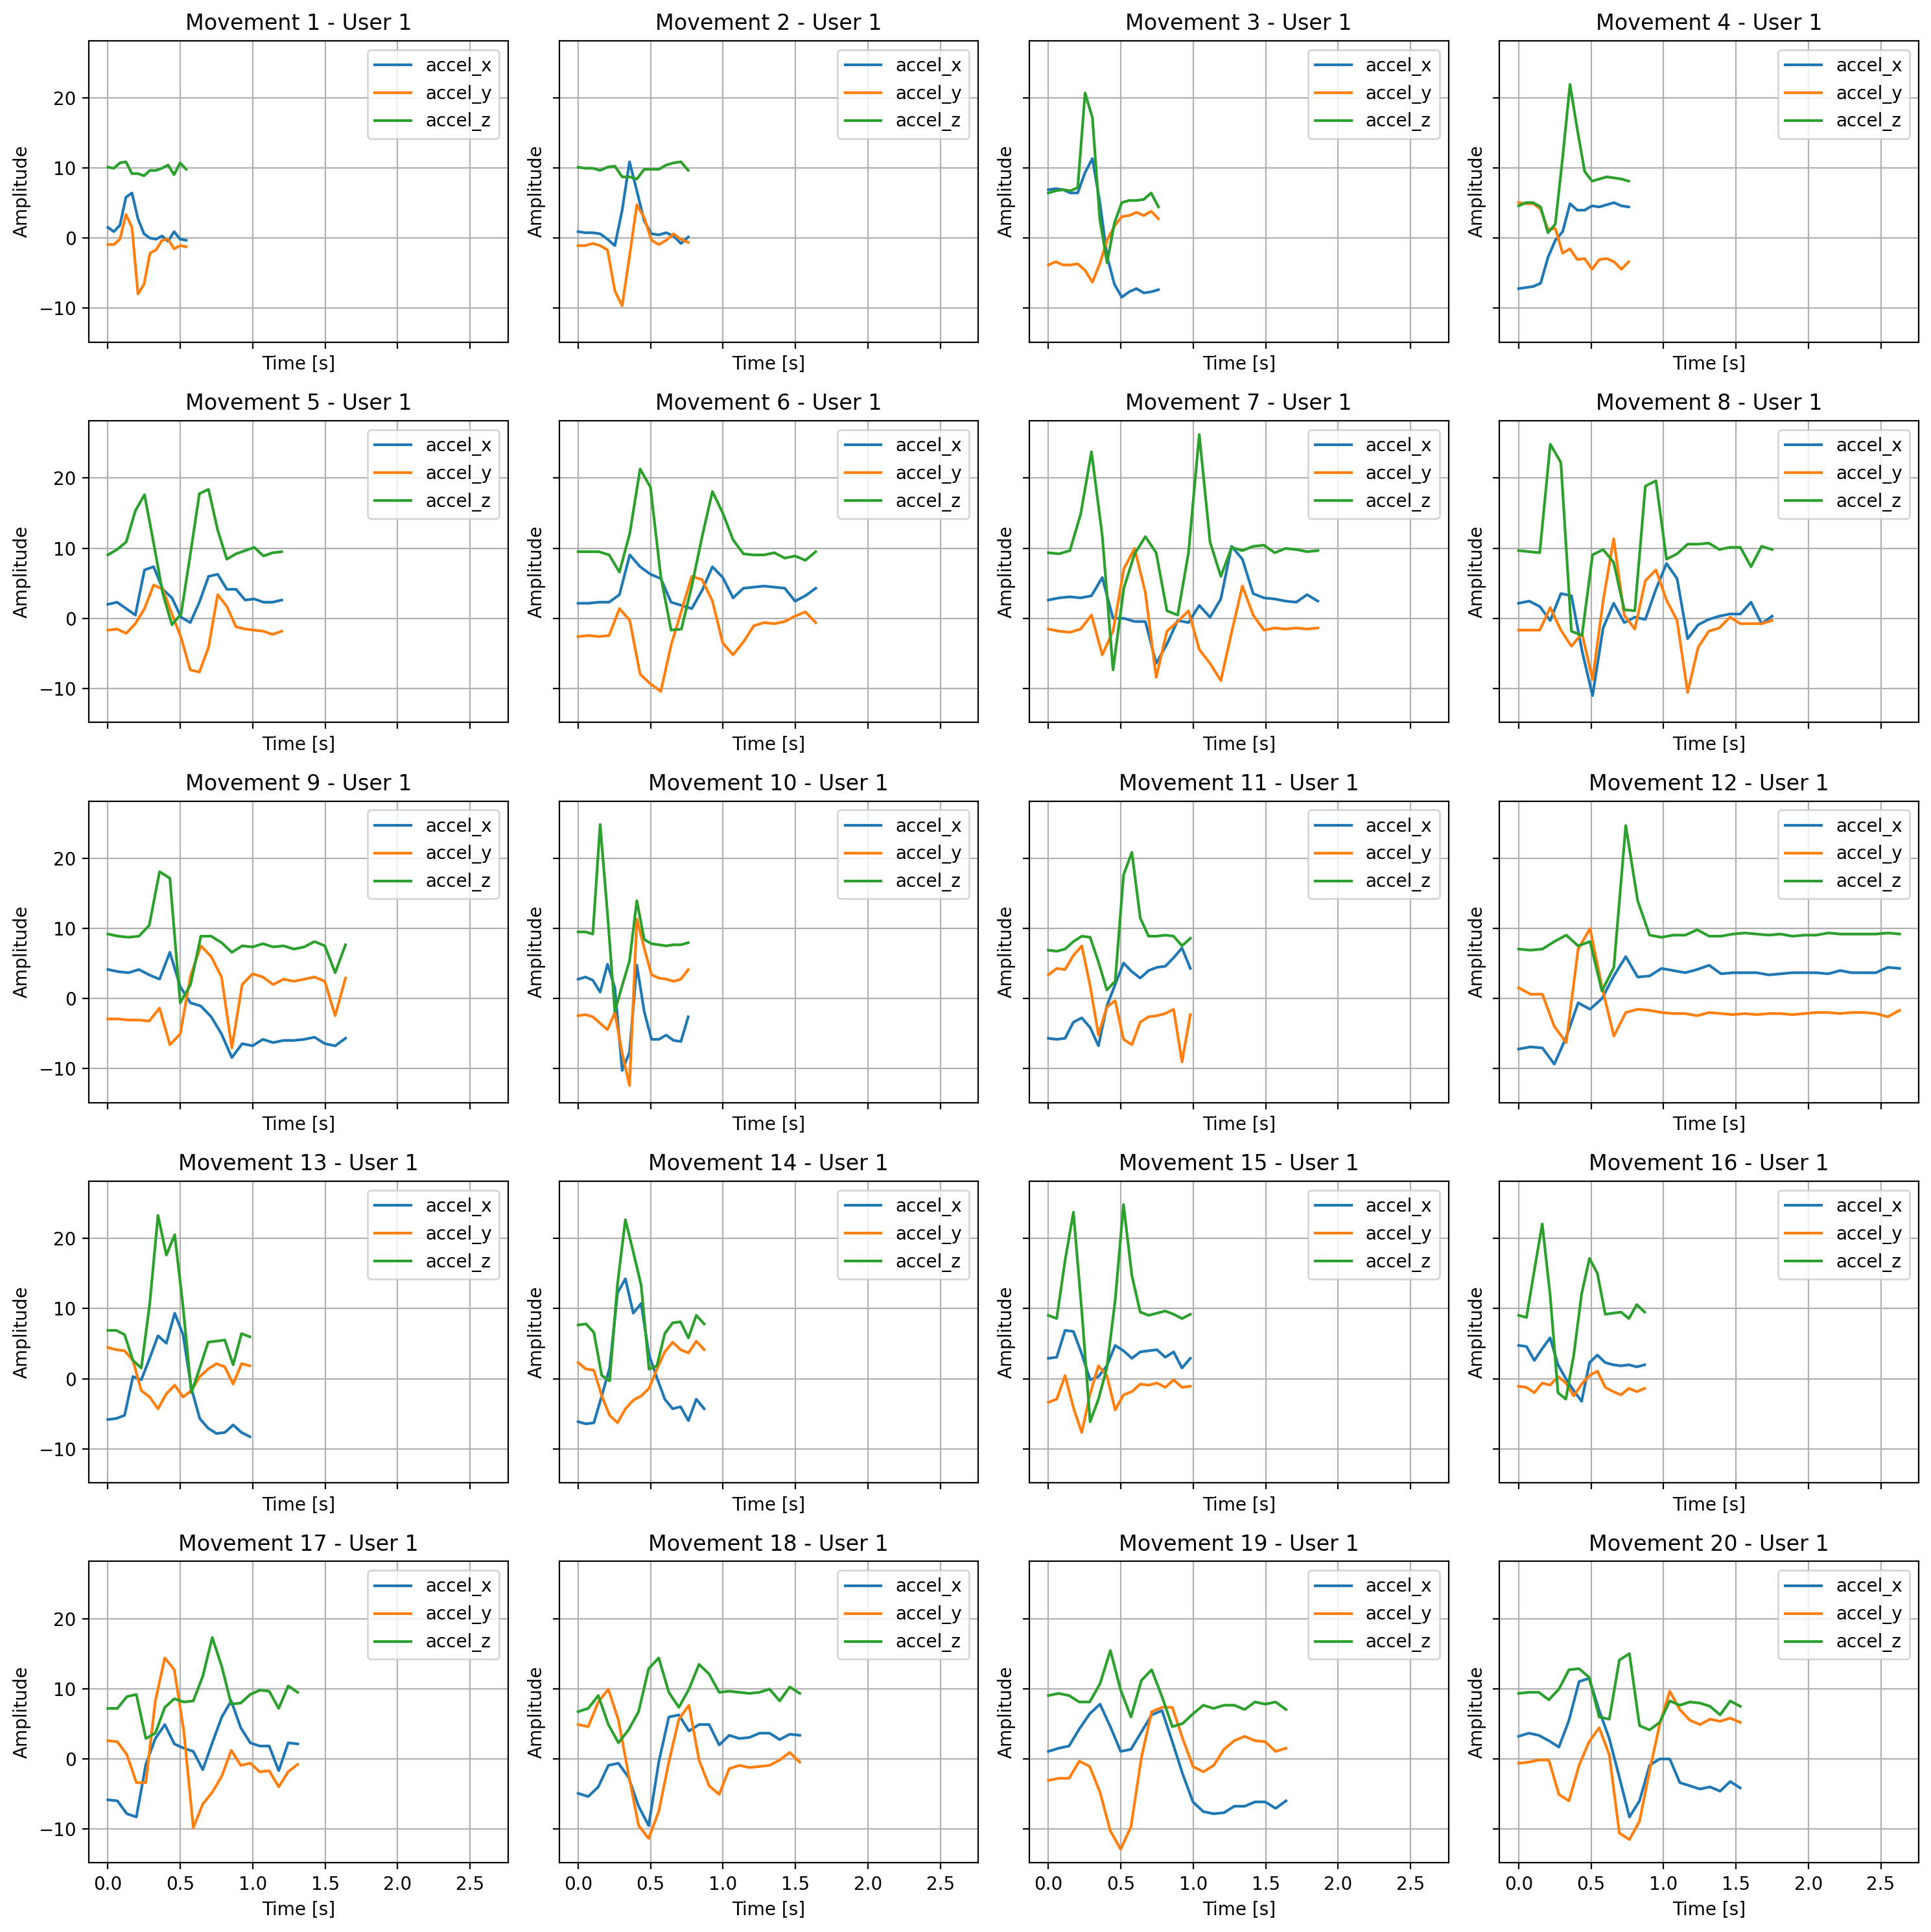

In [14]:
sensor_names = ['accel_x', 'accel_y', 'accel_z']
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15,15), dpi=200, sharex=True, sharey=True)

for move, ax in zip(np.arange(1,21),axes.ravel()):
    move_data = movements[move-1]
    length = move_data.shape[0]
    index = np.linspace(0,(0.11*length)-1,length)
    ax.plot(index,move_data[:,0],label='accel_x')
    ax.plot(index,move_data[:,1],label='accel_y')
    ax.plot(index,move_data[:,2],label='accel_z')
    ax.set_title(f'Movement {move} - User {user}')
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Time [s]')
    ax.grid(visible=True, which='major', axis='both')
    ax.legend()
    
fig.tight_layout()

# Maximum and average lines contained in csv files

As all the timeseries lengths vary it is useful to know how long the longest series is. This allows the remaining series to be padded to the same length.

In [15]:
max_lines = 0
lines_count = []
for item in file_paths:
    with open(item,'r') as file:
        reader = csv.reader(file, delimiter=' ')
        lines= len(list(reader))
        lines_count.append(lines)
        if lines > max_lines:
            max_lines = lines

average_lines = np.mean(lines_count)
print(f'Maximum lines in a csv file: {max_lines}')
print(f'Average lines in a csv file: {average_lines:.0f}')

Maximum lines in a csv file: 51
Average lines in a csv file: 20


# Set features constant

In [16]:
FEATURES = 3 # this is just the number of sensors (accel_x, accel_y and accel_z)

# Get files per user

In [17]:
# count files per user

files_per_user = np.zeros(shape=(8,),dtype='int')
for item in file_paths:
    user = int(item[-12:-10]) - 1 # zero index by minus 1
    files_per_user[user] = files_per_user[user] + 1

files_per_user

array([401, 417, 429, 400, 402, 401, 400, 401])

In thoery there should be 3200 total timeseries, which is 400 series per each of the 8 paticipants. However, it appears in reality this varies a little, with a total of 3251 total timeseries.

# Get all data and mean of each feature to calculate some stats

In [18]:
total_files = len(file_paths)
mean_x = []
mean_y = []
mean_z = []
all_x = np.zeros(shape=(0,1),dtype='float32')
all_y = np.zeros(shape=(0,1),dtype='float32')
all_z = np.zeros(shape=(0,1),dtype='float32')
for item in file_paths:
    current_file = np.loadtxt(item, delimiter=' ', converters=None, skiprows=0, usecols=(3,4,5))
    mean_x.append(np.average(current_file[:,0]))
    mean_y.append(np.average(current_file[:,1]))
    mean_z.append(np.average(current_file[:,2]))
    all_x = np.append(all_x,current_file[:,0])
    all_y = np.append(all_y,current_file[:,1])
    all_z = np.append(all_z,current_file[:,2])
average_x = np.average(mean_x)
average_y = np.average(mean_y)
average_z = np.average(mean_z)

averages = [average_x,average_y,average_z]
averages

[3.3927004042630102, -1.3677151619386383, 7.904521628966384]

In [19]:
all_x.shape, all_y.shape, all_z.shape

((64070,), (64070,), (64070,))

# Check the data distribution

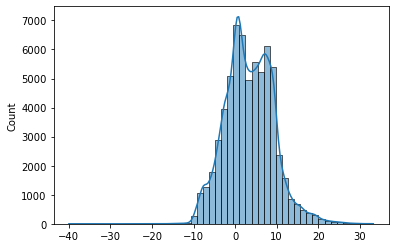

In [20]:
sns.histplot(all_x,bins=50,kde=True);

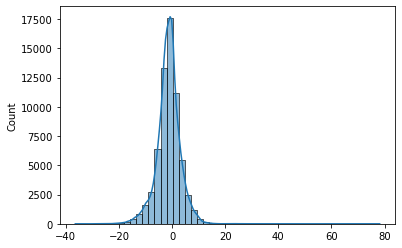

In [21]:
sns.histplot(all_y,bins=50,kde=True);

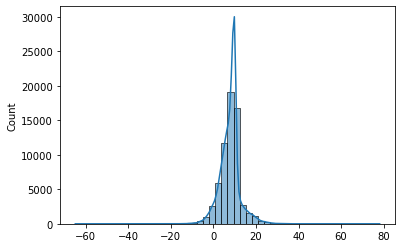

In [22]:
sns.histplot(all_z,bins=50,kde=True);

The data looks to be relatively normally distributed across all three sensors. This would therefore be a good candidate for StandardScaler provided by SciKitLearn. It also looks as though the z accelerometer has a gravity component in the readings as the offset of the distribution is very close to the value of 9.81 as would be expected. Again using StandardScaler would remove this offset by setting the mean to 0.

# Fit StandardScaler for future use

In theory, scaling data based on the whole dataset is not best practise, as you will inevitably leak information from the training dataset across to the validation and test sets. In this case, for simplicity/flexibility, this fact is ignored, and the scaling information is obtained from the complete dataset.

In [23]:
all_data = np.array([all_x,all_y,all_z]).T
all_data.shape

(64070, 3)

In [24]:
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(all_data)
print(f'Mean: {scaler.mean_} StdDev: {scaler.scale_}')

Mean: [ 3.45580339 -1.35401073  7.87322043] StdDev: [5.80265072 4.39467679 4.81358559]


# Extract data into train and val sets

In [25]:
def extract_train_val_test_data(user_files,test_user,max_lines,data_file_paths, scale_data=False, scaler=scaler):
    """
    Extract training-validation and test sets from raw text data files 
    
    Can also apply optional scaling of the data based on a scaler which utilises the fit() method. The scaler
    must be pre-fit before being passed into the function.
    
    Parameters
    ----------
        user_files : list of int 
            an array containing the amount of raw data files for each user.
        test_user : int
            the user to use as test data (value from 1 to 8).
        max_lines : int
            the maximum number of lines the timeseries data contains (i.e. max samples per timeseries).
        data_file_paths : list of str
            a list of the file paths of each raw data file.
        scale_data : bool, default False
            apply the scaler or not.
        scaler : sklearn.preprocessing.Scaler 
            a fitted scaler from sklearns preprocessing library.
  
    Returns
    -------
        X_train_val : ragged_tensor of float32 
            train and validation data.
        y_train_val : array of int
            train and validation labels.
        user_train_val : array of int
            train and validation data's associated users.
        X_test : ragged_tensor of float32 
            test data.
        y_test : array of int
            test labels.
        user_test : array of int
            test data's associated users.
    """
    test_user_string = f'U0{test_user}'
    features = 3
    
    # load train-val data
    
    files_train = user_files[:test_user-1].sum()
    if test_user < 8:
        files_train = files_train + user_files[test_user:].sum()
    X_train_val = []
    y_train_val = np.ndarray(shape=(files_train,), dtype = 'int')
    user_train_val = np.ndarray(shape=(files_train,), dtype = 'int')
    count = 0
    for item in data_file_paths:
        if test_user_string not in item:
            current_file = np.loadtxt(item, delimiter=' ', converters=None, skiprows=0, usecols=(3,4,5))
            if scale_data:
                current_file = scaler.transform(current_file)
            X_train_val.append(current_file)
            y_train_val[count] = int(item[-9:-7]) - 1 # minus 1 to make it zero indexed
            user_train_val[count] = item[-12:-10]
            count += 1
            
    # load test data
    
    files_test = user_files[test_user-1]
    X_test = []
    y_test = np.ndarray(shape=(files_test,), dtype = 'int')
    user_test = np.ndarray(shape=(files_test,), dtype = 'int')
    count = 0
    for item in data_file_paths:
        if test_user_string in item:
            current_file = np.loadtxt(item, delimiter=' ', converters=None, skiprows=0, usecols=(3,4,5))
            if scale_data:
                current_file = scaler.transform(current_file)
            X_test.append(current_file)
            y_test[count] = int(item[-9:-7]) - 1 # minus 1 to make it zero indexed
            user_test[count] = item[-12:-10]
            count += 1
            
    X_train_val = tf.ragged.constant(X_train_val, dtype=tf.float32)
    X_test = tf.ragged.constant(X_test, dtype=tf.float32)
    
    return X_train_val, y_train_val, user_train_val, X_test, y_test, user_test

In [26]:
X_train_val, y_train_val, user_train_val, X_test, y_test, user_test = extract_train_val_test_data(files_per_user,8,max_lines,file_paths, True, scaler)

2022-07-01 12:14:13.125524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-01 12:14:13.453712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6922 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


In [27]:
X_train_val.shape, y_train_val.shape, user_train_val.shape

(TensorShape([2850, None, None]), (2850,), (2850,))

In [28]:
X_train_val.shape, X_train_val.bounding_shape()

(TensorShape([2850, None, None]),
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([2850,   51,    3])>)

In [29]:
print(f'The filename is: {file_paths[326]}, which is user: {user_train_val[326]}, and movement number: {y_train_val[326]} [this is zero indexed so the real movement number is {y_train_val[326] + 1}]')

The filename is: gestures-dataset/U01/17/07.txt, which is user: 1, and movement number: 16 [this is zero indexed so the real movement number is 17]


In [30]:
X_test.shape, y_test.shape, user_test.shape

(TensorShape([401, None, None]), (401,), (401,))

In [31]:
X_test.shape, X_test.bounding_shape()

(TensorShape([401, None, None]),
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([401,  32,   3])>)

# Explore data

The 'selected_data' parameter below can be changed to have a look at different timeseries from the dataset

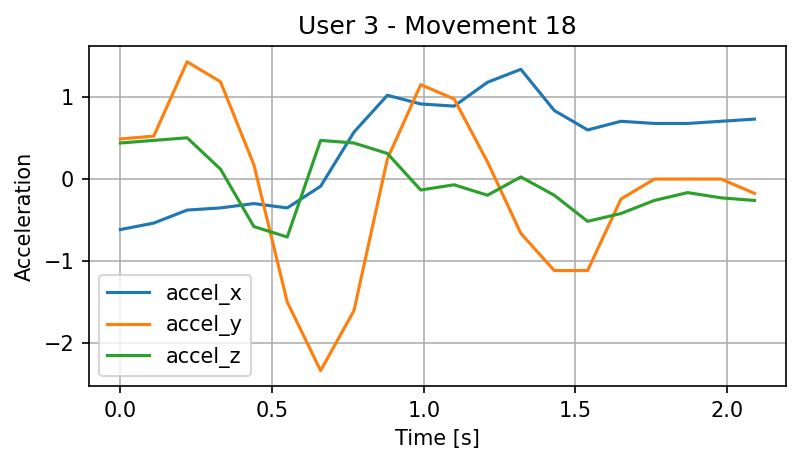

In [32]:
selected_data = 1200

plot_data = X_train_val[selected_data].numpy()
index = np.linspace(0,(len(plot_data)-1)*0.11,len(plot_data))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3), dpi=150)
ax.plot(index,plot_data[:,0],label='accel_x')
ax.plot(index,plot_data[:,1],label='accel_y')
ax.plot(index,plot_data[:,2],label='accel_z')
ax.set_title(f'User {user_train_val[selected_data]} - Movement {y_train_val[selected_data] + 1}')
ax.set_ylabel('Acceleration')
ax.set_xlabel('Time [s]')
ax.grid(visible=True, which='major', axis='both')
ax.legend();

# Scale data

Extract the largest absolute value present across accel_x, accel_y and accel_z.

This will later be used in a scaling layer in the model to scale all the acceleration data between -1 and 1. 

I have deliberately taken the largest value across the thee columns (rather than each individual column) to keep the relative magnitudes of each sensor intact.

In [33]:
max_value = max(tf.reduce_max(X_train_val), tf.abs(tf.reduce_min(X_train_val))).numpy()
max_value

18.090239

# Pad sequences

Because the data sequences are of varying length it is necessary to pad the sequences to a consistent shape to be able to feed them into the Conv1D and Conv2D layers that will later be encountered in the models.

To acheive this we will take a slightly different approach to the padding depending on whether it is intended to be passed to a cwt transform or just a straight timeseries:

* **Straight time series**: pad_value of -9999.0 (to be far away from real values), and a masking layer in the model to ignore the padding values
* **CWT transformed**: pad_value of 0 to be a neutral value to feed into the transform with the rest of the data. As the data has been 'normalised' using the StandardScaler the timeseries of all three censors should be around centred around zero, so using a padding value of zero should be the most neutral

Therefore, two base sets of data will be created for each input type.

In [34]:
def pad_sequences(seq,pad_value=-9999.0):
    shape1 = seq.bounding_shape()[0].numpy()
    shape2 = 51 # FIXED VALUE: depending on the data split, reading this value from the sequence array may result 
                # in a smaller value which is not compatible with the model
    shape3 = seq.bounding_shape()[2].numpy()
    padded_seq = seq.to_tensor(default_value=tf.constant(pad_value, dtype='float32'), shape=[shape1, shape2, shape3])
    return padded_seq

In [35]:
# timeseries padded input data arrays
X_train_val_pad = pad_sequences(X_train_val).numpy()
X_test_pad = pad_sequences(X_test).numpy()

# CWT padded input data arrays
X_train_val_pad_cwt = pad_sequences(X_train_val,pad_value=0.0).numpy()
X_test_pad_cwt = pad_sequences(X_test,pad_value=0.0).numpy()

In [36]:
X_train_val_pad.shape, X_test_pad.shape, X_train_val_pad_cwt.shape, X_test_pad_cwt.shape

((2850, 51, 3), (401, 51, 3), (2850, 51, 3), (401, 51, 3))

# Train / Val split

The two sets are created using the same seed value to ensure the split is identical

In [37]:
# timeseries
X_train, X_val, y_train, y_val = train_test_split(X_train_val_pad, y_train_val, test_size=0.15, random_state=SEED)

# CWT
X_train_cwt, X_val_cwt, y_train_cwt, y_val_cwt = train_test_split(X_train_val_pad_cwt, y_train_val, test_size=0.15, random_state=SEED)

In [38]:
X_train.shape, X_train_cwt.shape

((2422, 51, 3), (2422, 51, 3))

In [39]:
# The two datasets are not the same due to differing padding values

(X_train != X_train_cwt).any()

True

In [40]:
# The elements before the padding begins are identical (i.e. the train/val split is identical between sets)

(X_train[:,:10,:] == X_train_cwt[:,:10,:]).all()

True

# Create and prep datasets for basic Conv1D Model

In [41]:
# train
X_train_ds = tf.data.Dataset.from_tensor_slices(X_train)
y_train_ds = tf.data.Dataset.from_tensor_slices(y_train)
train_ds = tf.data.Dataset.zip((X_train_ds, y_train_ds))

# val
X_val_ds = tf.data.Dataset.from_tensor_slices(X_val)
y_val_ds = tf.data.Dataset.from_tensor_slices(y_val)
val_ds = tf.data.Dataset.zip((X_val_ds, y_val_ds))

In [42]:
# Prep datasets for model
train_ds = train_ds.shuffle(buffer_size=1000,seed=SEED).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

train_ds, val_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 51, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 51, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Define label names

In [43]:
label_names = np.arange(1,21)
label_names = label_names.astype('str')
label_names

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'], dtype='<U21')

# Plotting Functions

In [44]:
def plot_history(history):
    """
    Plot a line graph of training accuracy against validation accuracy per epoch.
    
    Parameters
    ----------
        history : keras.callbacks.History 
            history output from a trained model.
    """
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3), dpi=150)
    ax.plot(np.arange(len(accuracy)) + 1,accuracy,label='accuracy')
    ax.plot(np.arange(len(accuracy)) + 1,val_accuracy,label='val_accuracy')
    ax.set_title('Accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.grid(visible=True, which='major', axis='both')
    ax.set_xlim(1,len(accuracy))
    ax.set_ylim(0,1.0)
    ax.legend()

def plot_loss_lr(history):
    """
    Plot a line graph of loss vs learning rate.
    
    Parameters
    ----------
        history : keras.callbacks.History 
            history output from a trained model.
    """
    loss = history.history['loss']
    lr = history.history['lr']
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3), dpi=150)
    ax.plot(lr,loss)
    ax.set_xscale('log')
    ax.set_title('Learning Rate vs Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Learning Rate')
    ax.set_ylim(0,4)
    ax.grid(visible=True, which='major', axis='both')
    ax.grid(visible=True, which='minor', axis='x')

def plot_confusion_matrix(model, y_test, X_test, labels):
    """
    Plot confusion matrix graphic.
    
    Parameters
    ----------
        model : tf.keras.Model 
            a trained TensorFlow model.
        y_test : array-like
            array of true labels.
        X_test : array-like
            array of input data.
        labels : arr of str
            array of label names.
    """
    y_pred = tf.argmax(model.predict(X_test),axis=1)
    y_true = y_test
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8),dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_true,y_pred,display_labels=labels,ax=ax, xticks_rotation='vertical',cmap='plasma')

# Printing Functions

In [45]:
def print_accuracy(history):
    """
    Print final accuracy, final validation accuracy and 
    maximum validation accuracy across training epochs.
    
    Parameters
    ----------
        history : keras.callbacks.History 
            history output from a trained model.
    """
    print(f"Accuracy: {history.history['accuracy'][-1]:.2f}  Val_Accuracy: {history.history['val_accuracy'][-1]:.2f} Val_Accuracy_MAX: {np.amax(history.history['val_accuracy']):.2f}")

def make_classification_report(model, y_test, X_test, labels):
    """
    Print a classification report.
    
    Parameters
    ----------
        model : tf.keras.Model 
            a trained TensorFlow model.
        y_test : array-like
            array of true labels.
        X_test : array-like
            array of input data.
        labels : arr of str
            array of label names.
    """
    y_pred = tf.argmax(model.predict(X_test),axis=1)
    y_true = y_test
    return print(classification_report(y_true,y_pred,target_names=labels))

def get_accuracy_score(model, y_test, X_test):
    """
    Calculate the accuracy score.
    
    Parameters
    ----------
        model : tf.keras.Model 
            a trained TensorFlow model.
        y_test : array-like
            array of true labels.
        X_test : array-like
            array of input data.
    """
    y_pred = tf.argmax(model.predict(X_test),axis=1)
    y_true = y_test
    return accuracy_score(y_true,y_pred)

# Model Functions

In [46]:
def scheduler(epoch, lr):
    if (epoch % 20) == 0 and epoch > 5:
        return lr * 0.5
    else:
        return lr

def create_model(model_number, scaling_value, input_shape):
    """
    Create a required model architecture.
    
    Parameters
    ----------
        model_number : int 
            the model number you want to create.
        scaling_value : float
            a value to scale the data down by. typically the maximum value of the series of interest. 
        input_shape : tuple of int
            the required input shape to the model.
  
    Returns
    -------
        model : tf.keras.Model
            a keras / tensorflow model.
    """
    # Adjust scaling_value to be a multiplier
    
    scaling_value = (1. / scaling_value)

    # Model 1 - for raw timeseries data
    if model_number == 1:
        model = Sequential([
                        Input(shape=input_shape),
                        Masking(mask_value=-9999.0),
                        Rescaling(scaling_value),
                        Conv1D(filters=64,kernel_size=4,strides=1,padding='valid',kernel_initializer='glorot_uniform',activation='relu'),
                        MaxPooling1D(),
                        Dropout(0.2),
                        Conv1D(filters=32,kernel_size=1,strides=1,padding='valid',kernel_initializer='glorot_uniform',activation='relu'),
                        MaxPooling1D(),
                        Flatten(),
                        Dense(64, activation='relu'),
                        Dropout(0.2),
                        Dense(20,activation='softmax')
        ],name='Conv1D_Model_1')

    # Model 2 - for CWT images

    elif model_number == 2:
        model = Sequential([
                    Input(shape=input_shape),
                    Rescaling(scaling_value),
                    Conv2D(filters=64,kernel_size=4,strides=1,padding='valid',kernel_initializer='glorot_uniform',activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(filters=32,kernel_size=1,strides=1,padding='valid',kernel_initializer='glorot_uniform',activation='relu'),
                    MaxPooling2D(),
                    Flatten(),
                    Dense(64, activation='relu'),
                    Dropout(0.2),
                    Dense(20,activation='softmax')
        ],name='CWT_Model_2')

    
        
    # Model 3 - for CWT images (complex)
    
    else:
        model = Sequential([
                    Input(shape=input_shape),
                    Rescaling(scaling_value),
                    Conv2D(filters=64,kernel_size=4,strides=1,padding='valid',kernel_initializer='glorot_uniform',activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(filters=32,kernel_size=1,strides=1,padding='valid',kernel_initializer='glorot_uniform',activation='relu'),
                    MaxPooling2D(),
                    Flatten(),
                    Dense(64, activation='relu'),
                    Dropout(0.2),
                    Dense(20,activation='softmax')
        ],name='CWT_Comp_Model_3')
        
    return model


def compile_and_fit(model_number, train_dataset, test_dataset, scaling_value, input_shape, epochs=10, lr=0.001, tune_learning_rate=False, verbose=2):
    # Clear session and set seed
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(SEED)
    # create model

    model = create_model(model_number, scaling_value, input_shape)

    # compile and fit model

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    
    # set learning rate scheduler and checkpoint callbacks

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
    checkpoint_path = f'{model.name}/cp.ckpt'
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss',verbose=verbose,save_best_only=True,save_weights_only=True)
    callbacks=[lr_scheduler,checkpoint_callback]
    
    # if tuning model turn of checkpoints and adjust the learning rate scheduler

    if tune_learning_rate:
        lr_scheduler=[tf.keras.callbacks.LearningRateScheduler(lambda epoch: 5e-6 * 10 ** (epoch / 30))]
        callbacks=[lr_scheduler]

    history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=callbacks, verbose=verbose)

    return model, history

# Model 1 - Conv1D

In [47]:
_ , history_model_1_tuning = compile_and_fit(1, train_ds, val_ds, max_value, (max_lines,FEATURES) , epochs=150, tune_learning_rate=True, verbose=0)

2022-07-01 12:14:14.597498: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


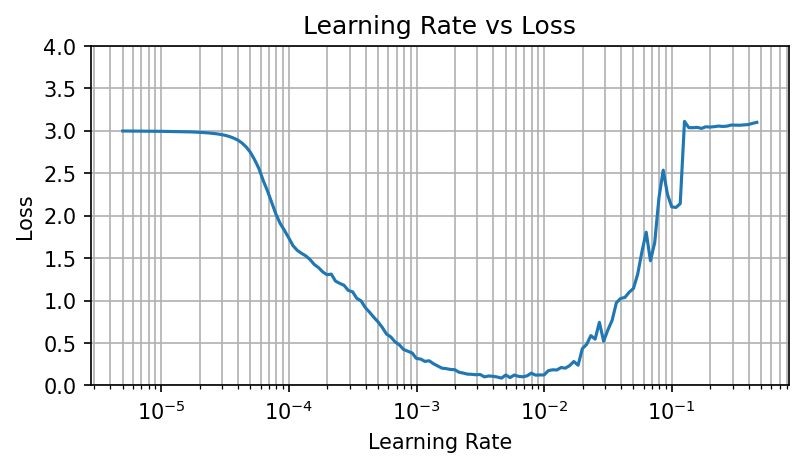

In [48]:
plot_loss_lr(history_model_1_tuning)

# Model 1 - Learning Rate

The initial learning rate will be set as 5 x 10^-3 (0.005) based on the above curve

In [49]:
model_1_lr = 0.005

# Model 1 - Train Model

In [63]:
model_1 , history_1 = compile_and_fit(1, train_ds, val_ds, max_value, (max_lines,FEATURES) , epochs=50, lr=model_1_lr, tune_learning_rate=False)

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.19150, saving model to Conv1D_Model_1/cp.ckpt
76/76 - 1s - loss: 2.2064 - accuracy: 0.2469 - val_loss: 1.1915 - val_accuracy: 0.5117 - lr: 0.0050 - 507ms/epoch - 7ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.19150 to 0.71115, saving model to Conv1D_Model_1/cp.ckpt
76/76 - 0s - loss: 1.1395 - accuracy: 0.5685 - val_loss: 0.7111 - val_accuracy: 0.7991 - lr: 0.0050 - 153ms/epoch - 2ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.71115 to 0.44007, saving model to Conv1D_Model_1/cp.ckpt
76/76 - 0s - loss: 0.6774 - accuracy: 0.7704 - val_loss: 0.4401 - val_accuracy: 0.8621 - lr: 0.0050 - 154ms/epoch - 2ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.44007 to 0.31166, saving model to Conv1D_Model_1/cp.ckpt
76/76 - 0s - loss: 0.5045 - accuracy: 0.8274 - val_loss: 0.3117 - val_accuracy: 0.9042 - lr: 0.0050 - 157ms/epoch - 2ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.31166 to 0.20349, saving model to Conv1D_Model

76/76 - 0s - loss: 0.0271 - accuracy: 0.9926 - val_loss: 0.0868 - val_accuracy: 0.9883 - lr: 0.0012 - 226ms/epoch - 3ms/step
Epoch 43/50

Epoch 43: val_loss did not improve from 0.06796
76/76 - 0s - loss: 0.0249 - accuracy: 0.9926 - val_loss: 0.0898 - val_accuracy: 0.9883 - lr: 0.0012 - 165ms/epoch - 2ms/step
Epoch 44/50

Epoch 44: val_loss did not improve from 0.06796
76/76 - 0s - loss: 0.0260 - accuracy: 0.9922 - val_loss: 0.0843 - val_accuracy: 0.9907 - lr: 0.0012 - 134ms/epoch - 2ms/step
Epoch 45/50

Epoch 45: val_loss did not improve from 0.06796
76/76 - 0s - loss: 0.0229 - accuracy: 0.9926 - val_loss: 0.0918 - val_accuracy: 0.9883 - lr: 0.0012 - 162ms/epoch - 2ms/step
Epoch 46/50

Epoch 46: val_loss did not improve from 0.06796
76/76 - 0s - loss: 0.0199 - accuracy: 0.9942 - val_loss: 0.0884 - val_accuracy: 0.9883 - lr: 0.0012 - 247ms/epoch - 3ms/step
Epoch 47/50

Epoch 47: val_loss did not improve from 0.06796
76/76 - 0s - loss: 0.0269 - accuracy: 0.9893 - val_loss: 0.0876 - val_

In [64]:
model_1.load_weights(f'{model_1.name}/cp.ckpt')

Accuracy: 0.99  Val_Accuracy: 0.99 Val_Accuracy_MAX: 0.99


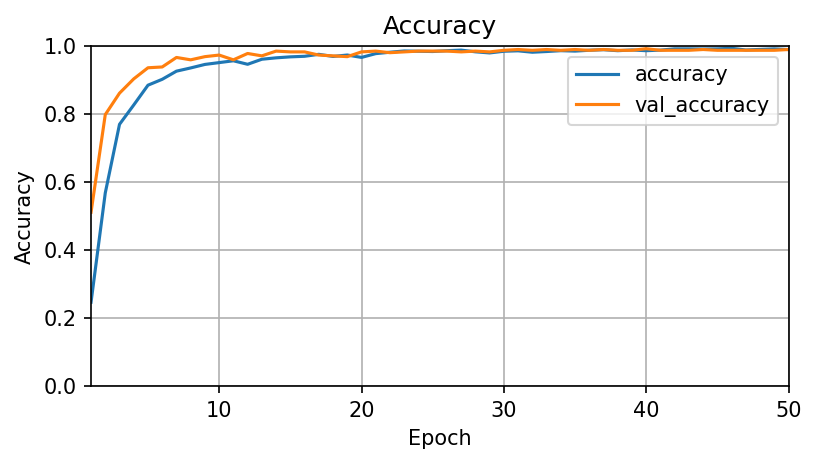

In [65]:
print_accuracy(history_1)
plot_history(history_1)

13/13 [==============================] - 0s 2ms/step


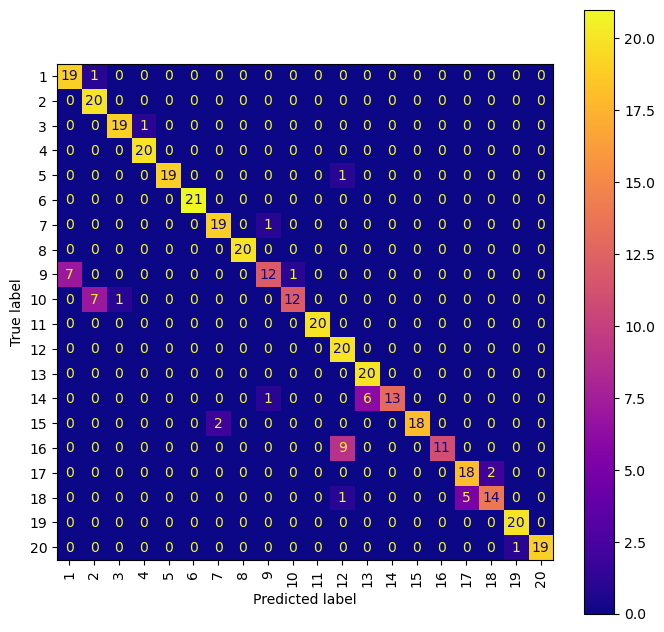

In [66]:
plot_confusion_matrix(model_1, y_test, X_test_pad, label_names)

In [67]:
make_classification_report(model_1, y_test, X_test_pad, label_names)

13/13 [==============================] - 0s 936us/step
              precision    recall  f1-score   support

           1       0.73      0.95      0.83        20
           2       0.71      1.00      0.83        20
           3       0.95      0.95      0.95        20
           4       0.95      1.00      0.98        20
           5       1.00      0.95      0.97        20
           6       1.00      1.00      1.00        21
           7       0.90      0.95      0.93        20
           8       1.00      1.00      1.00        20
           9       0.86      0.60      0.71        20
          10       0.92      0.60      0.73        20
          11       1.00      1.00      1.00        20
          12       0.65      1.00      0.78        20
          13       0.77      1.00      0.87        20
          14       1.00      0.65      0.79        20
          15       1.00      0.90      0.95        20
          16       1.00      0.55      0.71        20
          17       0.78   

# Get average of 10 runs

In [55]:
model_1_val_results = np.zeros(shape=(10,),dtype='float32')
model_1_test_results = np.zeros(shape=(10,),dtype='float32')

for run in tqdm((np.arange(1,11)-1),desc = 'Running tests: '):
    
    model , history = compile_and_fit(1, train_ds, val_ds, max_value, (max_lines,FEATURES) , epochs=50, lr=model_1_lr, tune_learning_rate=False,verbose=0)
    model.load_weights(f'{model.name}/cp.ckpt')
    model_1_val_results[run] = history.history['val_accuracy'][-1]
    model_1_test_results[run] = get_accuracy_score(model, y_test, X_test_pad)
    
test_accuracy = np.average(model_1_test_results)
val_accuracy = np.average(model_1_val_results)
    
print(f'Test Accuracy: {test_accuracy:.2f} Val Accuracy: {val_accuracy:.2f}')
    

Running tests:   0%|                                     | 0/10 [00:00<?, ?it/s]

13/13 [==============================] - 0s 875us/step


Running tests:  10%|██▉                          | 1/10 [00:08<01:14,  8.23s/it]

13/13 [==============================] - 0s 915us/step


Running tests:  20%|█████▊                       | 2/10 [00:16<01:06,  8.26s/it]

13/13 [==============================] - 0s 900us/step


Running tests:  30%|████████▋                    | 3/10 [00:23<00:54,  7.82s/it]

13/13 [==============================] - 0s 934us/step


Running tests:  40%|███████████▌                 | 4/10 [00:31<00:46,  7.68s/it]

13/13 [==============================] - 0s 946us/step


Running tests:  50%|██████████████▌              | 5/10 [00:38<00:38,  7.64s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  60%|█████████████████▍           | 6/10 [00:46<00:30,  7.58s/it]

13/13 [==============================] - 0s 882us/step


Running tests:  70%|████████████████████▎        | 7/10 [00:53<00:22,  7.58s/it]

13/13 [==============================] - 0s 909us/step


Running tests:  80%|███████████████████████▏     | 8/10 [01:01<00:15,  7.59s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  90%|██████████████████████████   | 9/10 [01:09<00:07,  7.58s/it]

13/13 [==============================] - 0s 886us/step


Running tests: 100%|████████████████████████████| 10/10 [01:16<00:00,  7.64s/it]

Test Accuracy: 0.86 Val Accuracy: 0.99


In [56]:
model_1_test_results

array([0.8578554 , 0.840399  , 0.8703242 , 0.8478803 , 0.8628429 ,
       0.87281793, 0.8553616 , 0.882793  , 0.83042395, 0.86533666],
      dtype=float32)

In [57]:
np.average(model_1_test_results)

0.8586035

# Creat Continuous Wavelet Transform (CWT) images

One of the items that first needs to be considered is what scales you wish to compute the continuous wavelet transform over, as this will decide how well the signal is represented in the output. 

The scales are arbitrary, but a sensible selection can be made by translating the scales into associated frequencies. Scales can be 'translated' into frequencies if the sample rate of the data is known. Basically, a small scale (1 for example) is related to a higher frequency, and a larger scale to a lower frequency. This is basically due to the increase in scale 'stretching' the wavelet, and hence being a better match to 'longer' signals (i.e. lower frequencies).

In our case the sample rate of the data is approximately 9Hz (0.11 seconds sample to sample). This is not a particularly high sample rate, so we need to retain as much of the data as possible.

Unfortunately, the CWT is subject to the Nyquist frequency, so in theory any frequency above 4.5Hz (half the sample frequency) could experience aliasing, which is not ideal as it will polute the signal.

At the other end of the scale:

Our longest signal is 51 timesteps long which is 5.61s (which is about 0.18Hz)
The average signal is 20 timesteps long which is 2.20s (which is about 0.45Hz)

This gives a good starting point for picking our scales. To keep the output small, as we are not using particularly deep neural networks, we will limit the lower frequency to about half the maximum, so ~0.36Hz and try to get as close to 4.5Hz as we can. This should give us a nice range to work with.

In [58]:
# Standard Morlet Wavelet frequencies at double the sampling frequency
dt = 0.11  # ~9 Hz sampling
input_scales = np.arange(2,22, dtype='float32')
input_scales = np.insert(input_scales,0,1.64)
frequencies = pywt.scale2frequency('morl', input_scales) / dt
frequencies

array([4.5038805 , 3.6931818 , 2.4621212 , 1.8465909 , 1.4772726 ,
       1.2310606 , 1.0551947 , 0.92329544, 0.8207071 , 0.7386363 ,
       0.67148757, 0.6155303 , 0.5681818 , 0.52759737, 0.49242425,
       0.46164772, 0.434492  , 0.41035354, 0.38875598, 0.36931816,
       0.35173163], dtype=float32)

In [62]:
# Complex Morlet Wavelet frequencies at double the sampling frequency
input_scales_comp = np.arange(2,27, dtype='float32')
frequencies = pywt.scale2frequency('cmor1.5-1.0', input_scales_comp) / dt
frequencies

array([4.5454545 , 3.0303032 , 2.2727273 , 1.8181819 , 1.5151516 ,
       1.2987014 , 1.1363636 , 1.0101011 , 0.90909094, 0.8264463 ,
       0.7575758 , 0.6993007 , 0.6493507 , 0.6060606 , 0.5681818 ,
       0.53475934, 0.50505054, 0.4784689 , 0.45454547, 0.43290043,
       0.41322315, 0.39525694, 0.3787879 , 0.36363634, 0.34965035],
      dtype=float32)

Based on the above the ranges following scale ranges will be used:

In [60]:
input_scales

array([ 1.64,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  ,
       10.  , 11.  , 12.  , 13.  , 14.  , 15.  , 16.  , 17.  , 18.  ,
       19.  , 20.  , 21.  ], dtype=float32)

In [61]:
input_scales_comp

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.],
      dtype=float32)

In [303]:
def create_cwt_images(X, scale_range, wavelet_name = 'morl', rescale=True, upsample=False, rescale_steps=30, rescale_scales=30):
    """
    Generate Continuous Wavelet Transform (CWT) array.
    
    Parameters
    ----------
        X : numpy.ndarray
            an array to be processed by the CWT transform, and 
            must have a 3D shape of (samples,timeseries,features).
        scale_range : list of float
            the start and stop scale for the scale_range. 
        wavelet_name : str, default 'morl'
            the mother wavelet that the CWT transform should use.
        rescale : bool, default True
            whether to rescale the output of the CWT transform to other dimensions
        upsample : bool, default False
            doubles the samples per timetrace
        rescale_scales : int, default 30
            the size to rescale the scales to if 'rescale' is set to True
        rescale_steps : int, default 30
            the size to rescale the steps to if 'rescale' is set to True
            
    Returns
    -------
        X_cwt : numpy.ndarray
            4D array of (samples, scales, timesteps, features).
    """
    samples = X.shape[0]
    steps = X.shape[1] 
    sensors = X.shape[2] 

    x_dim = steps
    y_dim = len(scale_range)
    
    if upsample:
        x_dim = x_dim * 2

    if rescale:
        x_dim = rescale_steps
        y_dim = rescale_scales
    
    
    # prepare the output array
    X_cwt = np.ndarray(shape=(samples, y_dim, x_dim, sensors), dtype = 'float32')
    
    for sample in tqdm(range(samples),desc = 'Creating CWT images: '):
        
        for sensor in range(sensors):
            series = X[sample, :, sensor]
            # upsample
            if upsample:
                x = np.linspace(1,len(series),len(series)*2)
                xp = np.arange(1,len(series)+1,dtype='float32')
                series = np.interp(x, xp, series)
            # continuous wavelet transform 
            coeffs, _ = pywt.cwt(series, scale_range, wavelet_name)
            # resize the 2D cwt coeffs
            if rescale:
                coeffs = resize(coeffs, (y_dim, x_dim), mode = 'constant')

            X_cwt[sample,:,:,sensor] = coeffs
            
    return X_cwt

In [304]:
scales = input_scales

X_train_cwt_im = create_cwt_images(X_train_cwt, scales, wavelet_name = "morl", rescale=False, upsample=False)
print(f"Shape (samples, scales, time, features) of X_train_cwt: {X_train_cwt.shape}")
X_val_cwt_im = create_cwt_images(X_val_cwt, scales, wavelet_name = "morl", rescale=False, upsample=False)
print(f"Shape (samples, scales, time, features) of X_test_cwt: {X_val_cwt.shape}")
X_test_cwt_im = create_cwt_images(X_test_pad_cwt, scales, wavelet_name = "morl", rescale=False, upsample=False)
print(f"Shape (samples, scales, time, features) of X_test_cwt: {X_test_pad_cwt.shape}")

Creating CWT images: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2422/2422 [00:06<00:00, 377.37it/s]


Shape (samples, scales, time, features) of X_train_cwt: (2422, 51, 3)


Creating CWT images: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 428/428 [00:01<00:00, 374.34it/s]


Shape (samples, scales, time, features) of X_test_cwt: (428, 51, 3)


Creating CWT images: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:01<00:00, 377.24it/s]

Shape (samples, scales, time, features) of X_test_cwt: (401, 51, 3)


In [305]:
#PLOT DATA FOR ARTICLE
# selected_sample = 1500
# sample = X_train_cwt_im[selected_sample,:,:,:]
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)

# axes.pcolormesh(sample[:,:,0], cmap = 'RdGy')
# axes.set_axis_off()
# fig.tight_layout()

# Scale Data CWT

In [306]:
max_value_cwt = np.abs(X_train_cwt_im).max()
max_value_cwt

7.55457

# Plot example images from each sensor

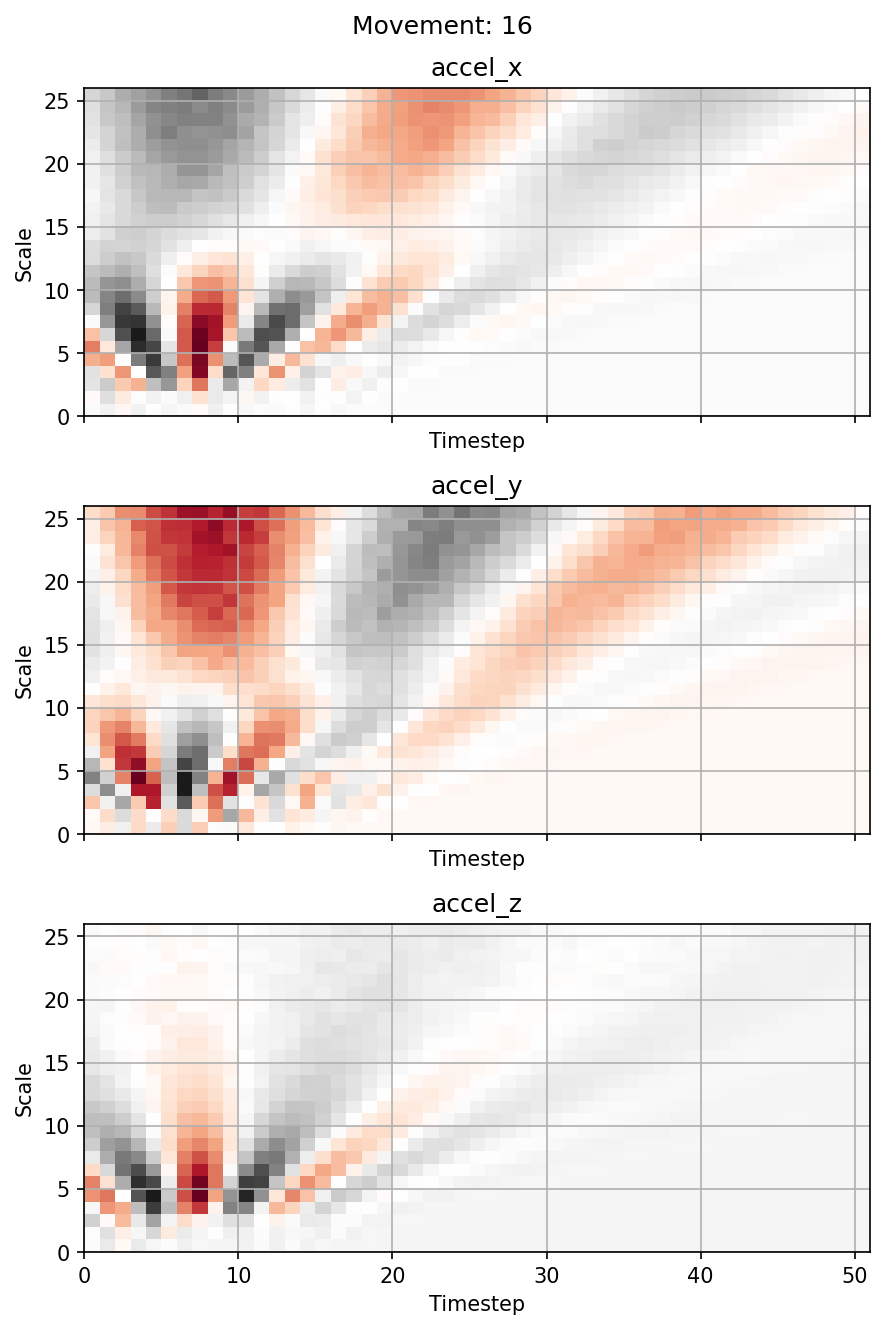

In [307]:
selected_sample = 300
sensors = ['accel_x', 'accel_y', 'accel_z']
sample = X_train_cwt_im[selected_sample,:,:,:]
fig, axes = plt.subplots(nrows=sample.shape[2], ncols=1, figsize=(6,9), dpi=150, sharex=True)

for sen in (np.arange(1,sample.shape[2]+1)-1):
    axes[sen].pcolormesh(sample[:,:,sen], cmap = 'RdGy')
    axes[sen].set_title(sensors[sen])
    axes[sen].set_ylabel('Scale')
    axes[sen].set_xlabel('Timestep')
    axes[sen].grid(visible=True, which='major', axis='both')
    
fig.suptitle(f'Movement: {label_names[y_train[selected_sample]]}')
fig.tight_layout()

In [308]:
X_train_cwt_ds = tf.data.Dataset.from_tensor_slices(X_train_cwt_im)
X_val_cwt_ds = tf.data.Dataset.from_tensor_slices(X_val_cwt_im)

# prep cwt train and test datasets

# train
train_cwt_ds = tf.data.Dataset.zip((X_train_cwt_ds, y_train_ds))
train_cwt_ds = train_cwt_ds.shuffle(buffer_size=500,seed=SEED).batch(32).prefetch(tf.data.AUTOTUNE)

# val
val_cwt_ds = tf.data.Dataset.zip((X_val_cwt_ds, y_val_ds))
val_cwt_ds = val_cwt_ds.batch(32).prefetch(tf.data.AUTOTUNE)

train_cwt_ds, val_cwt_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 26, 51, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 26, 51, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [309]:
input_shape_cwt = (X_train_cwt_im.shape[1], X_train_cwt_im.shape[2], X_train_cwt_im.shape[3])
input_shape_cwt

(26, 51, 3)

In [310]:
_ , history_model_2_tuning = compile_and_fit(2, train_cwt_ds, val_cwt_ds, max_value_cwt, input_shape_cwt, epochs=100, tune_learning_rate=True, verbose=0) 

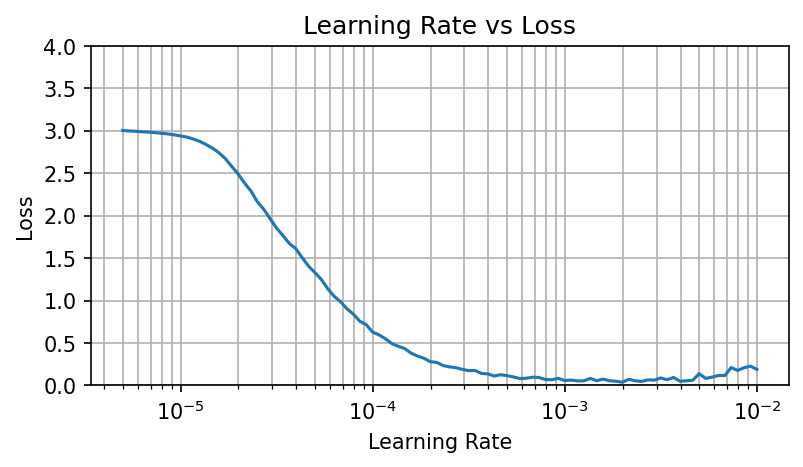

In [311]:
plot_loss_lr(history_model_2_tuning)

In [312]:
model_2_lr = 0.001

In [313]:
model_2 , history_2 = compile_and_fit(2, train_cwt_ds, val_cwt_ds, max_value_cwt, input_shape_cwt, epochs=50, lr=model_2_lr, tune_learning_rate=False)

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.48568, saving model to CWT_Model_2/cp.ckpt
76/76 - 1s - loss: 2.3706 - accuracy: 0.2510 - val_loss: 1.4857 - val_accuracy: 0.6075 - lr: 0.0010 - 936ms/epoch - 12ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.48568 to 0.60228, saving model to CWT_Model_2/cp.ckpt
76/76 - 0s - loss: 1.1341 - accuracy: 0.6379 - val_loss: 0.6023 - val_accuracy: 0.8575 - lr: 0.0010 - 216ms/epoch - 3ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.60228 to 0.36753, saving model to CWT_Model_2/cp.ckpt
76/76 - 0s - loss: 0.6585 - accuracy: 0.7907 - val_loss: 0.3675 - val_accuracy: 0.9042 - lr: 0.0010 - 222ms/epoch - 3ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.36753 to 0.28998, saving model to CWT_Model_2/cp.ckpt
76/76 - 0s - loss: 0.4373 - accuracy: 0.8613 - val_loss: 0.2900 - val_accuracy: 0.9206 - lr: 0.0010 - 228ms/epoch - 3ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.28998 to 0.17415, saving model to CWT_Model_2/cp.ckpt
76/

Epoch 41/50

Epoch 41: val_loss did not improve from 0.05321
76/76 - 0s - loss: 0.0256 - accuracy: 0.9938 - val_loss: 0.0609 - val_accuracy: 0.9907 - lr: 2.5000e-04 - 210ms/epoch - 3ms/step
Epoch 42/50

Epoch 42: val_loss did not improve from 0.05321
76/76 - 0s - loss: 0.0273 - accuracy: 0.9922 - val_loss: 0.0627 - val_accuracy: 0.9907 - lr: 2.5000e-04 - 206ms/epoch - 3ms/step
Epoch 43/50

Epoch 43: val_loss did not improve from 0.05321
76/76 - 0s - loss: 0.0296 - accuracy: 0.9905 - val_loss: 0.0681 - val_accuracy: 0.9907 - lr: 2.5000e-04 - 214ms/epoch - 3ms/step
Epoch 44/50

Epoch 44: val_loss did not improve from 0.05321
76/76 - 0s - loss: 0.0289 - accuracy: 0.9913 - val_loss: 0.0691 - val_accuracy: 0.9883 - lr: 2.5000e-04 - 206ms/epoch - 3ms/step
Epoch 45/50

Epoch 45: val_loss did not improve from 0.05321
76/76 - 0s - loss: 0.0284 - accuracy: 0.9934 - val_loss: 0.0691 - val_accuracy: 0.9860 - lr: 2.5000e-04 - 226ms/epoch - 3ms/step
Epoch 46/50

Epoch 46: val_loss did not improve fr

In [314]:
model_2.load_weights(f'{model_2.name}/cp.ckpt')

Accuracy: 0.99  Val_Accuracy: 0.99 Val_Accuracy_MAX: 0.99


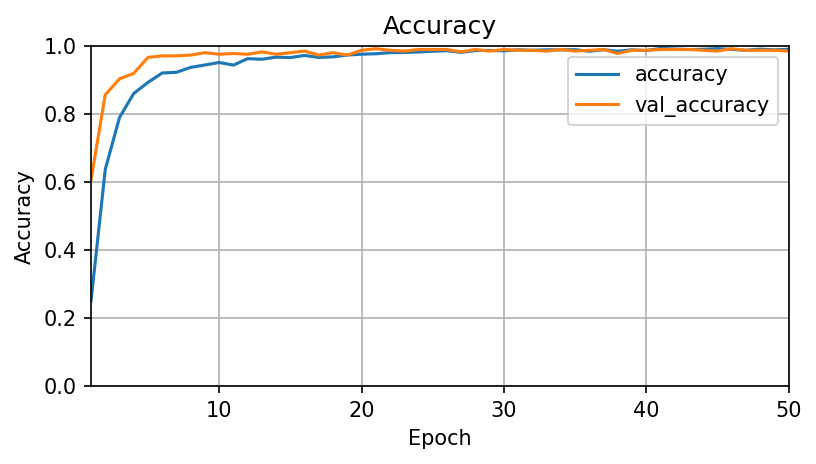

In [315]:
print_accuracy(history_2)
plot_history(history_2)

13/13 [==============================] - 0s 1ms/step


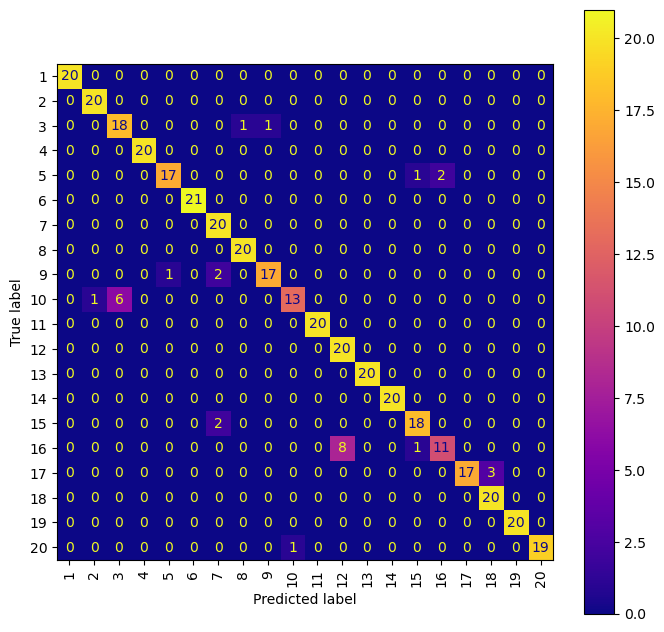

In [316]:
plot_confusion_matrix(model_2, y_test, X_test_cwt_im, label_names)

In [317]:
make_classification_report(model_2, y_test, X_test_cwt_im, label_names)

13/13 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       0.95      1.00      0.98        20
           3       0.75      0.90      0.82        20
           4       1.00      1.00      1.00        20
           5       0.94      0.85      0.89        20
           6       1.00      1.00      1.00        21
           7       0.83      1.00      0.91        20
           8       0.95      1.00      0.98        20
           9       0.94      0.85      0.89        20
          10       0.93      0.65      0.76        20
          11       1.00      1.00      1.00        20
          12       0.71      1.00      0.83        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        20
          15       0.90      0.90      0.90        20
          16       0.85      0.55      0.67        20
          17       1.00     

In [318]:
model_2_val_results = np.zeros(shape=(10,),dtype='float32')
model_2_test_results = np.zeros(shape=(10,),dtype='float32')

for run in tqdm((np.arange(1,11)-1),desc = 'Running tests: '):
    
    model , history = compile_and_fit(2, train_cwt_ds, val_cwt_ds, max_value_cwt, input_shape_cwt, epochs=50, lr=model_2_lr, tune_learning_rate=False,verbose=0)
    model.load_weights(f'{model.name}/cp.ckpt')
    model_2_val_results[run] = history.history['val_accuracy'][-1]
    model_2_test_results[run] = get_accuracy_score(model, y_test, X_test_cwt_im)
    
test_accuracy = np.average(model_2_test_results)
val_accuracy = np.average(model_2_val_results)
    
print(f'Test Accuracy: {test_accuracy:.2f} Val Accuracy: {val_accuracy:.2f}')

Running tests:   0%|                                                                                                                                                                                                                                               | 0/10 [00:00<?, ?it/s]

13/13 [==============================] - 0s 1ms/step


Running tests:  10%|███████████████████████                                                                                                                                                                                                                | 1/10 [00:11<01:40, 11.12s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  20%|██████████████████████████████████████████████▏                                                                                                                                                                                        | 2/10 [00:22<01:28, 11.04s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  30%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 3/10 [00:33<01:17, 11.08s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  40%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 4/10 [00:44<01:06, 11.09s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 5/10 [00:55<00:55, 11.11s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 6/10 [01:06<00:44, 11.09s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 7/10 [01:17<00:33, 11.08s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 8/10 [01:28<00:22, 11.04s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 9/10 [01:39<00:11, 11.04s/it]

13/13 [==============================] - 0s 1ms/step


Running tests: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:50<00:00, 11.06s/it]

Test Accuracy: 0.95 Val Accuracy: 0.99


In [319]:
model_2_test_results

array([0.9526185 , 0.93516207, 0.9401496 , 0.94763094, 0.93765587,
       0.94763094, 0.9401496 , 0.92518705, 0.9625935 , 0.9625935 ],
      dtype=float32)

In [320]:
np.average(model_2_test_results)

0.94513714

In [321]:
def create_cwt_images_complex_wavelet(X, scale_range, wavelet_name = 'cmor1.5-1.0', rescale=True, upsample=False, rescale_scales=30, rescale_steps=30):
    """
    Generate complex Continuous Wavelet Transform (CWT) array.
    
    The output doubles the number of features as it includes both the real and
    imaginary part of the coefficient output of the CWT.
    
    Parameters
    ----------
        X : numpy.ndarray
            an array to be processed by the CWT transform, and 
            must have a 3D shape of (samples,timeseries,features).
        scale_range : list of float
            the start and stop scale for the scale_range. 
        wavelet_name : str, default 'cmor1.5-1.0'
            the mother wavelet that the CWT transform should use.
        rescale : bool, default True
            whether to rescale the output of the CWT transform to other dimensions
        upsample : bool, default False
            doubles the samples per timetrace
        rescale_scales : int, default 30
            the size to rescale the scales to if 'rescale' is set to True
        rescale_steps : int, default 30
            the size to rescale the steps to if 'rescale' is set to True
            
    Returns
    -------
        X_cwt : numpy.ndarray
            4D array of (samples, scales, timesteps, features).
    Notes
    -----
    The output of this function are the real and imaginary parts of the complex output coefficients.
    In theory they could also be translated into magnitude and phase. I'm not sure this is 
    beneficial to a neural network, as it does not add data, but could be explored at a later date.
    """
    samples = X.shape[0]
    steps = X.shape[1] 
    sensors = X.shape[2] 

    x_dim = steps
    y_dim = len(scale_range)
    
    if upsample:
        x_dim = x_dim * 2

    if rescale:
        x_dim = rescale_steps
        y_dim = rescale_scales

    # prepare the output array
    X_cwt = np.ndarray(shape=(samples, y_dim, x_dim, sensors * 2), dtype = 'float32')
    
    #for sample in tqdm(range(samples),desc = 'Creating CWT images: '):
    for sample in range(samples):
        
        for sensor in range(sensors):
            series = X[sample, :, sensor]
            # upsample
            if upsample:
                x = np.linspace(1,len(series),len(series)*2)
                xp = np.arange(1,len(series)+1,dtype='float32')
                series = np.interp(x, xp, series)
            # continuous wavelet transform 
            coeffs, _ = pywt.cwt(series, scale_range, wavelet_name)
            coeffs_real = coeffs.real
            coeffs_imag = coeffs.imag
            # resize the 2D cwt coeffs
            if rescale:
                coeffs_real = resize(coeffs_real, (y_dim, x_dim), mode = 'constant')
                coeffs_imag = resize(coeffs_imag, (y_dim, x_dim), mode = 'constant')

            X_cwt[sample,:,:,sensor] = coeffs_real
            X_cwt[sample,:,:,sensor + sensors] = coeffs_imag
            
    return X_cwt

In [322]:
scales = input_scales_comp 

X_train_cwt_comp = create_cwt_images_complex_wavelet(X_train_cwt, scales, wavelet_name = 'cmor1.5-1.0', rescale=False, upsample=False)
print(f"shape (samples, scales, timesteps, sensor) of X_train_cwt_comp: {X_train_cwt_comp.shape}")
X_val_cwt_comp = create_cwt_images_complex_wavelet(X_val_cwt, scales, wavelet_name = 'cmor1.5-1.0', rescale=False, upsample=False)
print(f"shape (samples, scales, timesteps, sensor) of X_val_cwt_comp: {X_val_cwt_comp.shape}")
X_test_cwt_comp = create_cwt_images_complex_wavelet(X_test_pad_cwt, scales, wavelet_name = 'cmor1.5-1.0', rescale=False, upsample=False)
print(f"shape (samples, scales, timesteps, sensor) of X_val_cwt_comp: {X_val_cwt_comp.shape}")

shape (samples, scales, timesteps, sensor) of X_train_cwt_comp: (2422, 25, 51, 6)
shape (samples, scales, timesteps, sensor) of X_val_cwt_comp: (428, 25, 51, 6)
shape (samples, scales, timesteps, sensor) of X_val_cwt_comp: (428, 25, 51, 6)


In [323]:
max_value_cwt_comp = np.abs(X_train_cwt_comp).max()
max_value_cwt_comp

3.5400088

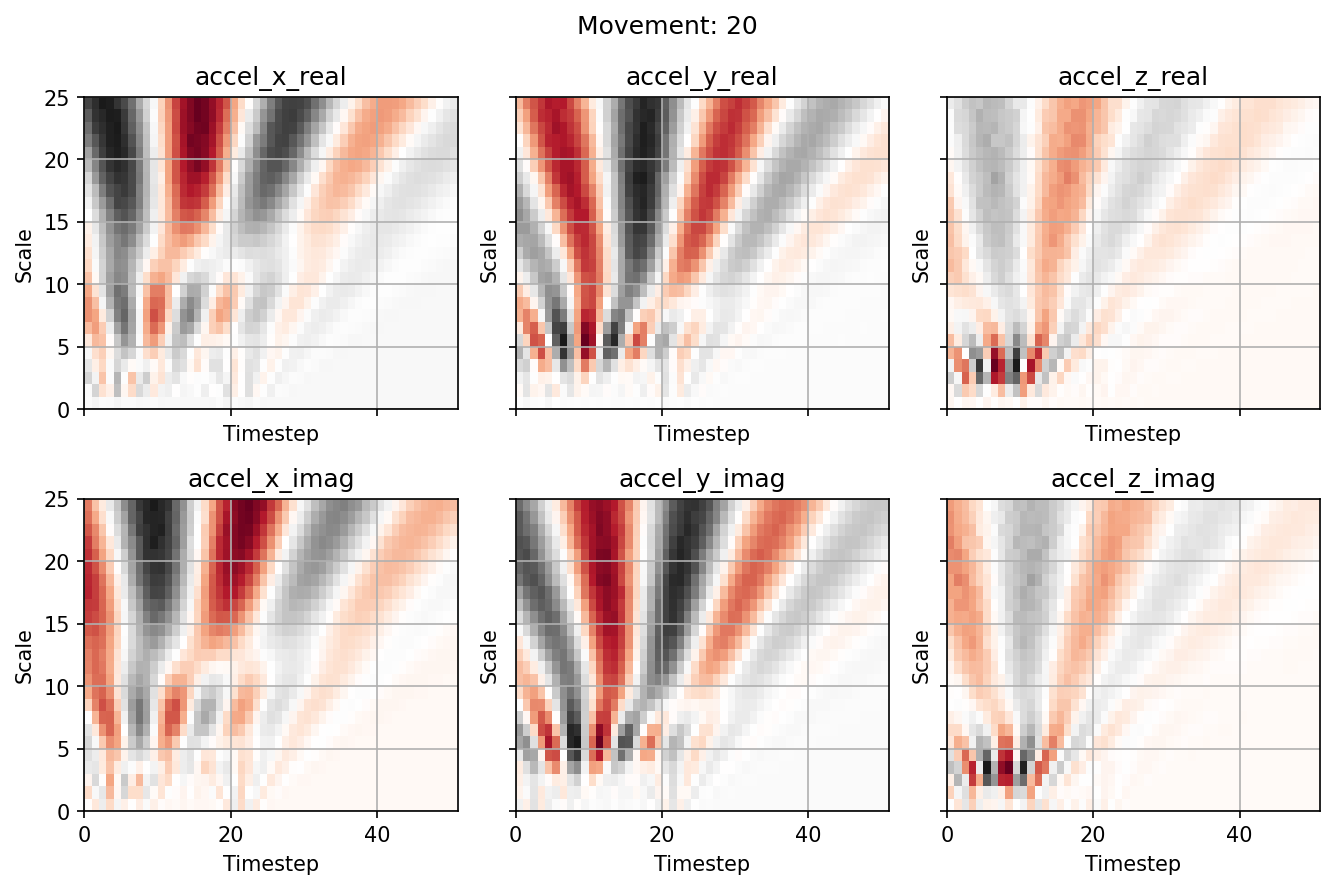

In [324]:
selected_sample = 750
sensors = ['accel_x_real', 'accel_y_real', 'accel_z_real','accel_x_imag', 'accel_y_imag', 'accel_z_imag']
sample = X_train_cwt_comp[selected_sample,:,:,:]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9,6), dpi=150, sharex=True, sharey=True)

for sen, ax in zip((np.arange(1,sample.shape[2]+1)-1),axes.ravel()):
    ax.pcolormesh(sample[:,:,sen], cmap = 'RdGy')
    ax.set_title(sensors[sen])
    ax.set_ylabel('Scale')
    ax.set_xlabel('Timestep')
    ax.grid(visible=True, which='major', axis='both')
    
fig.suptitle(f'Movement: {label_names[y_train[selected_sample]]}')
fig.tight_layout()

In [325]:
X_train_cwt_comp_ds = tf.data.Dataset.from_tensor_slices(X_train_cwt_comp)
X_val_cwt_comp_ds = tf.data.Dataset.from_tensor_slices(X_val_cwt_comp)

# prep cwt train and test datasets

# train
train_cwt_comp_ds = tf.data.Dataset.zip((X_train_cwt_comp_ds, y_train_ds))
train_cwt_comp_ds = train_cwt_comp_ds.shuffle(buffer_size=500,seed=SEED).batch(32).prefetch(tf.data.AUTOTUNE)

# val
val_cwt_comp_ds = tf.data.Dataset.zip((X_val_cwt_comp_ds, y_val_ds))
val_cwt_comp_ds = val_cwt_comp_ds.batch(32).prefetch(tf.data.AUTOTUNE)

train_cwt_comp_ds, val_cwt_comp_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 25, 51, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 25, 51, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [326]:
input_shape_cwt_comp = (X_train_cwt_comp.shape[1], X_train_cwt_comp.shape[2], X_train_cwt_comp.shape[3])
input_shape_cwt_comp

(25, 51, 6)

In [327]:
_ , history_model_3_tuning = compile_and_fit(3, train_cwt_comp_ds, val_cwt_comp_ds, max_value_cwt_comp, input_shape_cwt_comp, epochs=100, tune_learning_rate=True, verbose=0)

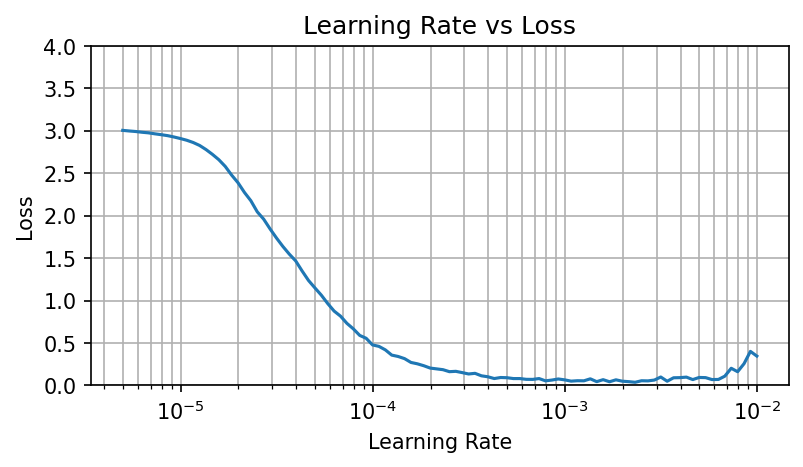

In [328]:
plot_loss_lr(history_model_3_tuning)

In [329]:
model_3_lr = 0.001

In [360]:
model_3 , history_3 = compile_and_fit(3, train_cwt_comp_ds, val_cwt_comp_ds, max_value_cwt_comp, input_shape_cwt_comp, epochs=50, lr=model_3_lr, tune_learning_rate=False) 

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.21317, saving model to CWT_Comp_Model_3/cp.ckpt
76/76 - 1s - loss: 2.2047 - accuracy: 0.3192 - val_loss: 1.2132 - val_accuracy: 0.6846 - lr: 0.0010 - 577ms/epoch - 8ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.21317 to 0.43977, saving model to CWT_Comp_Model_3/cp.ckpt
76/76 - 0s - loss: 0.8977 - accuracy: 0.7225 - val_loss: 0.4398 - val_accuracy: 0.8715 - lr: 0.0010 - 256ms/epoch - 3ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.43977 to 0.24902, saving model to CWT_Comp_Model_3/cp.ckpt
76/76 - 0s - loss: 0.4816 - accuracy: 0.8452 - val_loss: 0.2490 - val_accuracy: 0.9439 - lr: 0.0010 - 269ms/epoch - 4ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.24902 to 0.19929, saving model to CWT_Comp_Model_3/cp.ckpt
76/76 - 0s - loss: 0.3156 - accuracy: 0.9046 - val_loss: 0.1993 - val_accuracy: 0.9416 - lr: 0.0010 - 272ms/epoch - 4ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.19929 to 0.14194, saving model to CWT_

Epoch 42/50

Epoch 42: val_loss did not improve from 0.05848
76/76 - 0s - loss: 0.0161 - accuracy: 0.9946 - val_loss: 0.0677 - val_accuracy: 0.9907 - lr: 2.5000e-04 - 255ms/epoch - 3ms/step
Epoch 43/50

Epoch 43: val_loss did not improve from 0.05848
76/76 - 0s - loss: 0.0111 - accuracy: 0.9975 - val_loss: 0.0640 - val_accuracy: 0.9930 - lr: 2.5000e-04 - 259ms/epoch - 3ms/step
Epoch 44/50

Epoch 44: val_loss did not improve from 0.05848
76/76 - 0s - loss: 0.0138 - accuracy: 0.9963 - val_loss: 0.0616 - val_accuracy: 0.9930 - lr: 2.5000e-04 - 243ms/epoch - 3ms/step
Epoch 45/50

Epoch 45: val_loss did not improve from 0.05848
76/76 - 0s - loss: 0.0144 - accuracy: 0.9950 - val_loss: 0.0661 - val_accuracy: 0.9883 - lr: 2.5000e-04 - 241ms/epoch - 3ms/step
Epoch 46/50

Epoch 46: val_loss did not improve from 0.05848
76/76 - 0s - loss: 0.0114 - accuracy: 0.9959 - val_loss: 0.0664 - val_accuracy: 0.9907 - lr: 2.5000e-04 - 241ms/epoch - 3ms/step
Epoch 47/50

Epoch 47: val_loss did not improve fr

In [361]:
model_3.load_weights(f'{model_3.name}/cp.ckpt')

Accuracy: 1.00  Val_Accuracy: 0.99 Val_Accuracy_MAX: 0.99


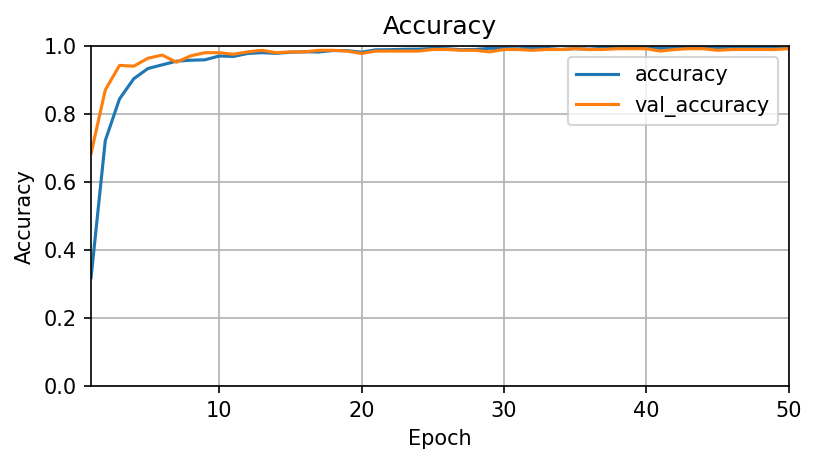

In [362]:
print_accuracy(history_3)
plot_history(history_3)

13/13 [==============================] - 0s 2ms/step


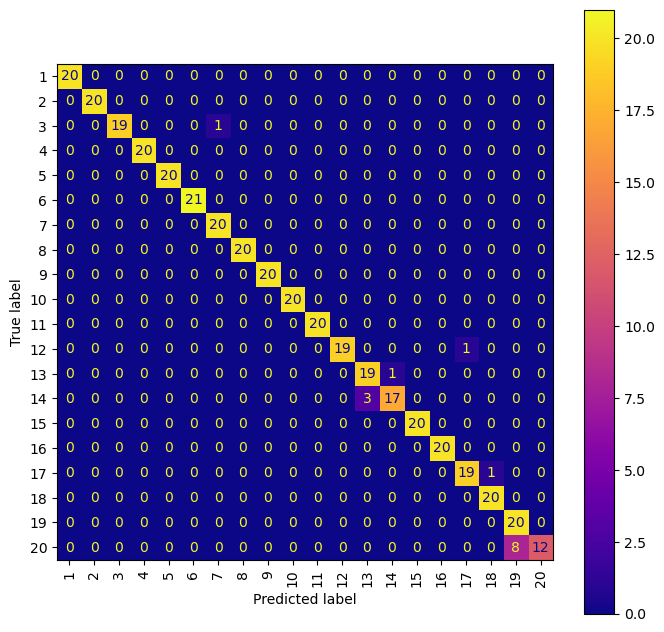

In [363]:
plot_confusion_matrix(model_3, y_test, X_test_cwt_comp, label_names)

In [364]:
make_classification_report(model_3, y_test, X_test_cwt_comp, label_names)

13/13 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      0.95      0.97        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        21
           7       0.95      1.00      0.98        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00        20
          12       1.00      0.95      0.97        20
          13       0.86      0.95      0.90        20
          14       0.94      0.85      0.89        20
          15       1.00      1.00      1.00        20
          16       1.00      1.00      1.00        20
          17       0.95     

In [335]:
model_3_val_results = np.zeros(shape=(10,),dtype='float32')
model_3_test_results = np.zeros(shape=(10,),dtype='float32')

for run in tqdm((np.arange(1,11)-1),desc = 'Running tests: '):
    
    model , history = compile_and_fit(3, train_cwt_comp_ds, val_cwt_comp_ds, max_value_cwt_comp, input_shape_cwt_comp, epochs=50, lr=model_3_lr, tune_learning_rate=False,verbose=0)
    model.load_weights(f'{model.name}/cp.ckpt')
    model_3_val_results[run] = history.history['val_accuracy'][-1]
    model_3_test_results[run] = get_accuracy_score(model, y_test, X_test_cwt_comp)
    
test_accuracy = np.average(model_3_test_results)
val_accuracy = np.average(model_3_val_results)
    
print(f'Test Accuracy: {test_accuracy:.2f} Val Accuracy: {val_accuracy:.2f}')

Running tests:   0%|                                                                                                                                                                                                                                               | 0/10 [00:00<?, ?it/s]

13/13 [==============================] - 0s 1ms/step


Running tests:  10%|███████████████████████                                                                                                                                                                                                                | 1/10 [00:12<01:49, 12.14s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  20%|██████████████████████████████████████████████▏                                                                                                                                                                                        | 2/10 [00:24<01:36, 12.07s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  30%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 3/10 [00:36<01:25, 12.15s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  40%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 4/10 [00:48<01:12, 12.14s/it]

13/13 [==============================] - 0s 2ms/step


Running tests:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 5/10 [01:00<01:00, 12.11s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 6/10 [01:12<00:48, 12.03s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 7/10 [01:24<00:36, 12.07s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 8/10 [01:36<00:24, 12.04s/it]

13/13 [==============================] - 0s 1ms/step


Running tests:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 9/10 [01:48<00:12, 12.03s/it]

13/13 [==============================] - 0s 1ms/step


Running tests: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:00<00:00, 12.07s/it]

Test Accuracy: 0.95 Val Accuracy: 0.99


In [336]:
model_3_test_results

array([0.9301746 , 0.9426434 , 0.9501247 , 0.97007483, 0.9625935 ,
       0.96758103, 0.9401496 , 0.94513714, 0.9526185 , 0.9625935 ],
      dtype=float32)

In [337]:
np.average(model_3_test_results)

0.95236903

# Compare Models

In [338]:
def plot_model_comparison(results_1, results_2, results_3):
    
    data = pd.DataFrame({'Model 1': results_1, 'Model 2': results_2, 'Model 3': results_3})
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,6), dpi=150)

    ax = sns.boxplot(data=data)
    ax.set_title('Accuracy Results per Model')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0.825,1.0)
    ax.grid(visible=True, which='major', axis='both')
    
#     fig.suptitle('Accuracy Results per Model')
    fig.tight_layout()

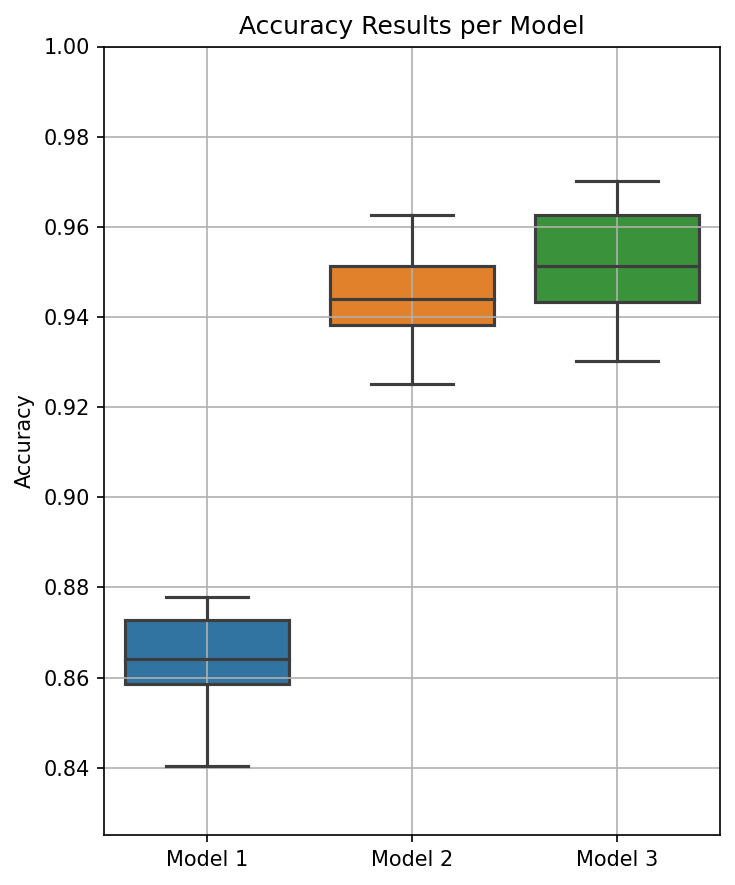

In [339]:
plot_model_comparison(model_1_test_results,model_2_test_results,model_3_test_results)

# Run cross validation of each user

In the previous sections we have explored the benefit of using the continuous wavelet transform in a neural network.

So far the hold out test set has been user 8. However, we have no idea whether this user is a good representation of the general population, or a fairly unique individual.

The next section will therefore run a cross validation across all users (i.e. each user will be the hold out test set for it's own set of train/val/test run).

This should give a much more reliable indication of the performance that has been acheived, especially considering the small size of the dataset.

To avoid any bias due to randomness, we will also repeat each test 10 times and take an average.

In [340]:
X_train_array = []
y_train_array = []
X_test_array = []
y_test_array = []

for user in np.arange(1,9):
    X_tr, y_tr, _, X_te, y_te, _ = extract_train_val_test_data(files_per_user,user,max_lines,file_paths,True,scaler)
    X_train_array.append(X_tr)
    y_train_array.append(y_tr)
    X_test_array.append(X_te)
    y_test_array.append(y_te)
    

In [341]:
model_1_val_res_avg = np.zeros(shape=(8,),dtype='float32')
model_1_test_res_avg = np.zeros(shape=(8,),dtype='float32')
model_1_val_res_raw = []
model_1_test_res_raw = []

for run in tqdm((np.arange(1,9)),desc = 'Running user tests: '):
    
    temp_val = np.zeros(shape=(10,),dtype='float32')
    temp_test = np.zeros(shape=(10,),dtype='float32')
    for repeat in np.arange(1,11):
        
        X_tra_pad = pad_sequences(X_train_array[run-1]).numpy()
        X_tes_pad = pad_sequences(X_test_array[run-1]).numpy()
        X_tra, X_va, y_tra, y_va = train_test_split(X_tra_pad, y_train_array[run-1], test_size=0.15, random_state=SEED)

        X_tra_ds = tf.data.Dataset.from_tensor_slices(X_tra)
        y_tra_ds = tf.data.Dataset.from_tensor_slices(y_tra)

        X_va_ds = tf.data.Dataset.from_tensor_slices(X_va)
        y_va_ds = tf.data.Dataset.from_tensor_slices(y_va)

        # train
        tra_ds = tf.data.Dataset.zip((X_tra_ds, y_tra_ds))
        tra_ds = tra_ds.shuffle(buffer_size=1000,seed=SEED).batch(32).prefetch(tf.data.AUTOTUNE)

        # val
        va_ds = tf.data.Dataset.zip((X_va_ds, y_va_ds))
        va_ds = va_ds.batch(32).prefetch(tf.data.AUTOTUNE)

        model , history = compile_and_fit(1, tra_ds, va_ds, max_value, (max_lines,FEATURES) , epochs=50, lr=model_1_lr, tune_learning_rate=False,verbose=0)
        model.load_weights(f'{model.name}/cp.ckpt')
        temp_val[repeat-1] = history.history['val_accuracy'][-1]
        temp_test[repeat-1] = get_accuracy_score(model, y_test_array[run-1], X_tes_pad)
    
    val_average = np.average(temp_val)
    test_average = np.average(temp_test)
    
    model_1_val_res_avg[run-1] = val_average
    model_1_test_res_avg[run-1] = test_average
    model_1_val_res_raw.append(temp_val)
    model_1_test_res_raw.append(temp_test)
    
test_acc = np.average(model_1_test_res_avg)
val_acc = np.average(model_1_val_res_avg)
    
print(f'Overall Test Accuracy: {test_acc:.2f} Overall Val Accuracy: {val_acc:.2f}')

Running user tests:   0%|                                                                                                                                                                                                                                           | 0/8 [00:00<?, ?it/s]

13/13 [==============================] - 0s 978us/step


Running user tests:  12%|████████████████████████████▍                                                                                                                                                                                                      | 1/8 [01:11<08:18, 71.15s/it]

14/14 [==============================] - 0s 933us/step


Running user tests:  25%|████████████████████████████████████████████████████████▊                                                                                                                                                                          | 2/8 [02:22<07:08, 71.47s/it]

14/14 [==============================] - 0s 1ms/step


Running user tests:  38%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 3/8 [03:33<05:55, 71.15s/it]

13/13 [==============================] - 0s 905us/step


Running user tests:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 4/8 [04:45<04:45, 71.47s/it]

13/13 [==============================] - 0s 932us/step


Running user tests:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 5/8 [05:57<03:35, 71.71s/it]

13/13 [==============================] - 0s 897us/step


Running user tests:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 6/8 [07:09<02:23, 71.89s/it]

13/13 [==============================] - 0s 1ms/step


Running user tests:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 7/8 [08:21<01:11, 71.64s/it]

13/13 [==============================] - 0s 958us/step


Running user tests: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [09:33<00:00, 71.63s/it]

Overall Test Accuracy: 0.88 Overall Val Accuracy: 0.99


In [342]:
model_1_test_res_avg

array([0.94962597, 0.8472422 , 0.90326345, 0.94425   , 0.9233831 ,
       0.898005  , 0.73424995, 0.85361594], dtype=float32)

In [343]:
def extract_mean_stdev(data):
    mean = np.zeros(shape=(8,),dtype='float32')
    stdev = np.zeros(shape=(8,),dtype='float32')
    for count, user in enumerate(data):
        print(f'User {count+1} - Average: {np.average(user):.2f} Standard Dev: {np.std(user):.3f}')
        mean[count] = np.average(user)
        stdev[count] = np.std(user)
    return mean, stdev

In [344]:
model_1_mean, model_1_stdev = extract_mean_stdev(model_1_test_res_raw)

User 1 - Average: 0.95 Standard Dev: 0.004
User 2 - Average: 0.85 Standard Dev: 0.009
User 3 - Average: 0.90 Standard Dev: 0.010
User 4 - Average: 0.94 Standard Dev: 0.007
User 5 - Average: 0.92 Standard Dev: 0.010
User 6 - Average: 0.90 Standard Dev: 0.009
User 7 - Average: 0.73 Standard Dev: 0.032
User 8 - Average: 0.85 Standard Dev: 0.013


In [345]:
model_3_val_res = np.zeros(shape=(8,),dtype='float32')
model_3_test_res = np.zeros(shape=(8,),dtype='float32')
model_3_val_res_raw = []
model_3_test_res_raw = []

scales = input_scales_comp

for run in tqdm((np.arange(1,9)),desc = 'Running user tests: '):
    
    temp_val_cwt = np.zeros(shape=(10,),dtype='float32')
    temp_test_cwt = np.zeros(shape=(10,),dtype='float32')
    for repeat in np.arange(1,11):
        
        X_tra_pad = pad_sequences(X_train_array[run-1],0.0).numpy()
        X_tes_pad = pad_sequences(X_test_array[run-1],0.0).numpy()
        X_tra, X_va, y_tra, y_va = train_test_split(X_tra_pad, y_train_array[run-1], test_size=0.15, random_state=SEED)

        X_tra_cwt_comp = create_cwt_images_complex_wavelet(X_tra, scales, wavelet_name = 'cmor1.5-1.0', rescale=False, upsample=False)
        X_va_cwt_comp = create_cwt_images_complex_wavelet(X_va, scales, wavelet_name = 'cmor1.5-1.0', rescale=False, upsample=False)
        X_te_cwt_comp = create_cwt_images_complex_wavelet(X_tes_pad, scales, wavelet_name = 'cmor1.5-1.0', rescale=False, upsample=False)

        X_tra_cwt_comp_ds = tf.data.Dataset.from_tensor_slices(X_tra_cwt_comp)
        y_tra_ds = tf.data.Dataset.from_tensor_slices(y_tra)
        
        X_va_cwt_comp_ds = tf.data.Dataset.from_tensor_slices(X_va_cwt_comp)
        y_va_ds = tf.data.Dataset.from_tensor_slices(y_va)
        
        # train
        tra_cwt_comp_ds = tf.data.Dataset.zip((X_tra_cwt_comp_ds, y_tra_ds))
        tra_cwt_comp_ds = tra_cwt_comp_ds.shuffle(buffer_size=500,seed=SEED).batch(32).prefetch(tf.data.AUTOTUNE)

        # val
        va_cwt_comp_ds = tf.data.Dataset.zip((X_va_cwt_comp_ds, y_va_ds))
        va_cwt_comp_ds = va_cwt_comp_ds.batch(32).prefetch(tf.data.AUTOTUNE)

        model , history = compile_and_fit(3, tra_cwt_comp_ds, va_cwt_comp_ds, max_value_cwt_comp, input_shape_cwt_comp, epochs=50, lr=model_3_lr, tune_learning_rate=False,verbose=0)
        model.load_weights(f'{model.name}/cp.ckpt')
        temp_val_cwt[repeat-1] = history.history['val_accuracy'][-1]
        temp_test_cwt[repeat-1] = get_accuracy_score(model, y_test_array[run-1], X_te_cwt_comp)
        
    val_average_cwt = np.average(temp_val_cwt)
    test_average_cwt = np.average(temp_test_cwt)
    
    model_3_val_res[run-1] = val_average_cwt
    model_3_test_res[run-1] = test_average_cwt
    model_3_val_res_raw.append(temp_val_cwt)
    model_3_test_res_raw.append(temp_test_cwt)
    
    
    
test_acc_cwt = np.average(model_3_test_res)
val_acc_cwt = np.average(model_3_val_res)
    
print(f'Test Accuracy: {test_acc_cwt:.2f} Val Accuracy: {val_acc_cwt:.3f}')

Running user tests:   0%|                                                                                                                                                                                                                                           | 0/8 [00:00<?, ?it/s]

13/13 [==============================] - 0s 2ms/step


Running user tests:  12%|████████████████████████████▎                                                                                                                                                                                                     | 1/8 [03:49<26:46, 229.49s/it]

14/14 [==============================] - 0s 1ms/step


Running user tests:  25%|████████████████████████████████████████████████████████▌                                                                                                                                                                         | 2/8 [07:41<23:06, 231.07s/it]

14/14 [==============================] - 0s 1ms/step


Running user tests:  38%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 3/8 [11:30<19:09, 229.99s/it]

13/13 [==============================] - 0s 1ms/step


Running user tests:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 4/8 [15:23<15:24, 231.09s/it]

13/13 [==============================] - 0s 1ms/step


Running user tests:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 5/8 [19:12<11:31, 230.64s/it]

13/13 [==============================] - 0s 1ms/step


Running user tests:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6/8 [23:04<07:41, 230.77s/it]

13/13 [==============================] - 0s 1ms/step


Running user tests:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 7/8 [26:53<03:50, 230.50s/it]

13/13 [==============================] - 0s 1ms/step


Running user tests: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [30:45<00:00, 230.74s/it]

Test Accuracy: 0.94 Val Accuracy: 0.990


In [346]:
model_3_test_res

array([0.9775561 , 0.92038375, 0.92470866, 0.92275   , 0.94900495,
       0.9588529 , 0.87999994, 0.9675811 ], dtype=float32)

In [347]:
model_3_mean, model_3_stdev = extract_mean_stdev(model_3_test_res_raw)

User 1 - Average: 0.98 Standard Dev: 0.004
User 2 - Average: 0.92 Standard Dev: 0.019
User 3 - Average: 0.92 Standard Dev: 0.006
User 4 - Average: 0.92 Standard Dev: 0.007
User 5 - Average: 0.95 Standard Dev: 0.015
User 6 - Average: 0.96 Standard Dev: 0.008
User 7 - Average: 0.88 Standard Dev: 0.010
User 8 - Average: 0.97 Standard Dev: 0.006


In [348]:
def plot_user_comparison(mean_model1, stdev_model1, mean_model3,stdev_model3, title):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4), dpi=150)

    ax[0].bar(np.arange(len(mean_model1)) + 0.8,mean_model1,label='Model 1',width=0.4)
    ax[0].bar(np.arange(len(mean_model3)) + 1.2,mean_model3,label='Model 3', width=0.4)
    ax[0].set_title('Mean')
    ax[0].set_ylabel('Mean Accuracy')
    ax[0].set_ylim(0.7,1.0)
    ax[0].legend(loc='lower left')
    
    ax[1].bar(np.arange(len(stdev_model1)) + 0.8,stdev_model1,label='Model 1', width=0.4)
    ax[1].bar(np.arange(len(stdev_model3)) + 1.2,stdev_model3,label='Model 3', width=0.4)
    ax[1].set_title('Standard Deviation')
    ax[1].set_ylabel('StDev Accuracy')
    ax[1].set_ylim(0,0.04)
    ax[1].legend(loc='upper left')
    
    for axes in ax:
        axes.set_xlim(0.6,8.4)
        axes.set_xlabel('Test Set User')
        axes.grid(visible=True, which='major', axis='both')
    
    fig.suptitle(title)
    fig.tight_layout()

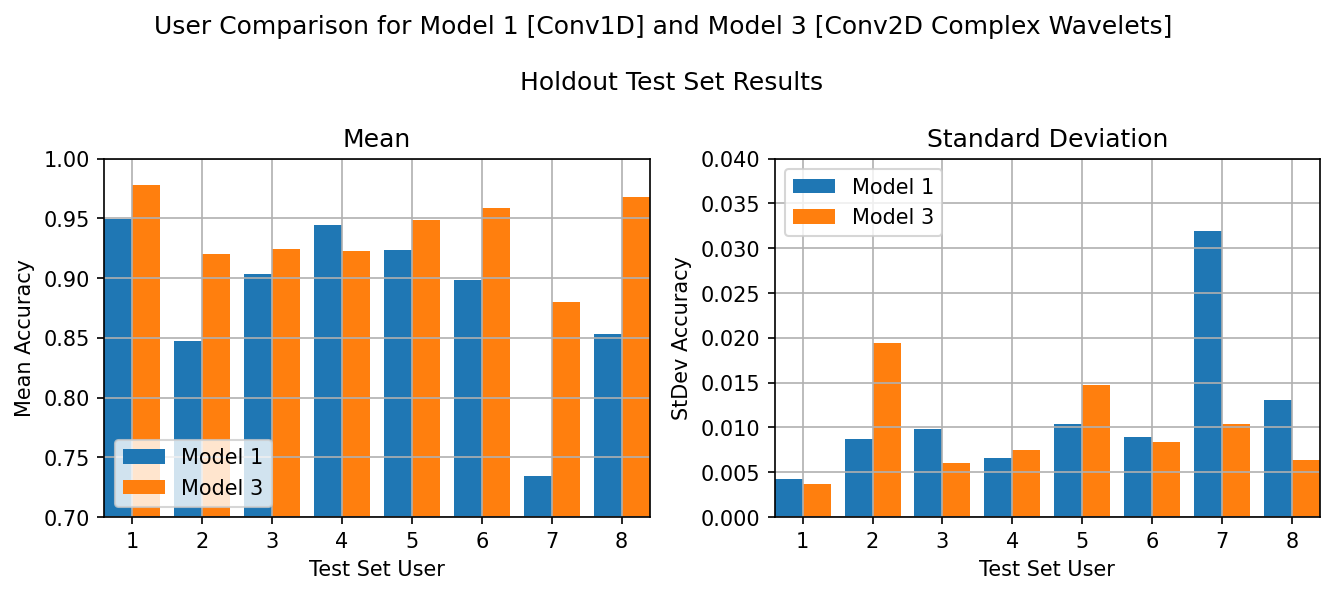

In [349]:
title = 'User Comparison for Model 1 [Conv1D] and Model 3 [Conv2D Complex Wavelets] \n\n Holdout Test Set Results'
plot_user_comparison(model_1_mean, model_1_stdev, model_3_mean,model_3_stdev, title)

# Validation Results

All of our results in the previous section are based on the hold out test set (as they should be). However, it is worth looking at the validation results as it gives an insight into how the models learn.

In [350]:
model_1_val_mean, model_1_val_stdev = extract_mean_stdev(model_1_val_res_raw)
model_3_val_mean, model_3_val_stdev = extract_mean_stdev(model_3_val_res_raw)

User 1 - Average: 0.98 Standard Dev: 0.003
User 2 - Average: 1.00 Standard Dev: 0.002
User 3 - Average: 0.99 Standard Dev: 0.001
User 4 - Average: 0.97 Standard Dev: 0.003
User 5 - Average: 0.99 Standard Dev: 0.003
User 6 - Average: 0.99 Standard Dev: 0.001
User 7 - Average: 0.98 Standard Dev: 0.001
User 8 - Average: 0.99 Standard Dev: 0.002
User 1 - Average: 0.99 Standard Dev: 0.002
User 2 - Average: 0.99 Standard Dev: 0.002
User 3 - Average: 0.99 Standard Dev: 0.001
User 4 - Average: 0.99 Standard Dev: 0.002
User 5 - Average: 0.99 Standard Dev: 0.001
User 6 - Average: 0.99 Standard Dev: 0.001
User 7 - Average: 0.99 Standard Dev: 0.002
User 8 - Average: 0.99 Standard Dev: 0.003


In [351]:
model_3_val_stdev

array([0.00203689, 0.00164319, 0.00070755, 0.00194079, 0.00114462,
       0.00070093, 0.00180982, 0.00276454], dtype=float32)

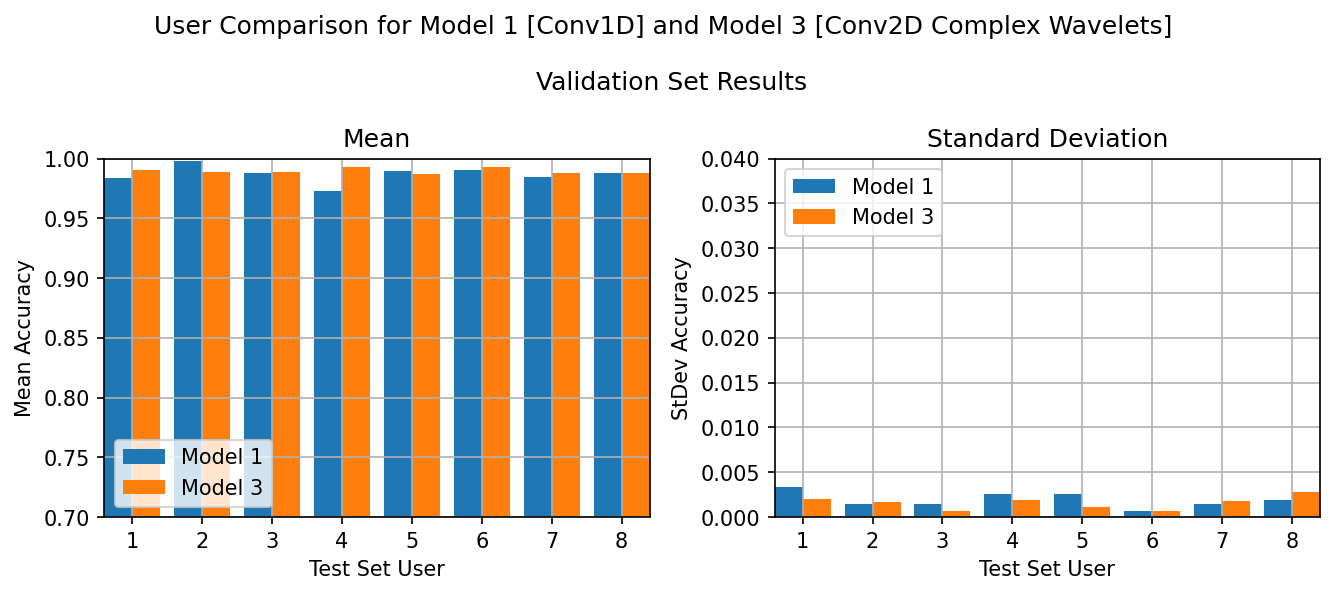

In [352]:
title = 'User Comparison for Model 1 [Conv1D] and Model 3 [Conv2D Complex Wavelets] \n\n Validation Set Results'
plot_user_comparison(model_1_val_mean, model_1_val_stdev, model_3_val_mean,model_3_val_stdev, title)

# Conclusion

It seems the hold out user really does matter! Although there are a wide variation of results, depending on the user, almost across the board the CWT transform outperforms the normal time series model (from 2% to 15% improvement). The exception, as you can see, is User 4, where the CWT is beaten on average by the normal model. Although it should be noted that there is only a 2% difference and even Model 3 managed 92% accuracy in this case.

Further to the above, it should be noted that the validation results across all tests and all users was very high (97%+). 

This indicates that although the models were able to learn the data provided to them equally well, the CWT model was able to both, pick out more relevant features, and generalise better than than the normal time series model.

In this particular case I think we can conclude that the CWT should definitely be considered as a tool in the arsenal of machine learning practitioners. It will not be suitable for every case, perhaps because of the additional overhead of processing that is required. However, it is a flexible tool that can be moulded to suit your specific data, and potentially improve indicators such as accuracy and bias.

This article has only really touched the surface, as no in depth tuning of parameters has been performed. Items like the complex parameters of the complex Morlet wavelet were fixed throughout this experiment, and plenty of experimentation of a suitable range of scales could be conducted, so there is plenty of scope for further investigation in to the CWTs use in machine learning.